# **Setup**


---



In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00


In [ ]:
pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.5 MB/s eta 0:00:00


In [ ]:
pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
import torch
from transformers import pipeline

In [ ]:
from io import StringIO
import pandas as pd

In [ ]:
import requests
from PyPDF2 import PdfReader
from io import BytesIO

def extract_content(url):
    text = ""
    response = requests.get(url)

    if response.status_code == 200:
        pdf_content = BytesIO(response.content)
        pdf_reader = PdfReader(pdf_content)

        for page in pdf_reader.pages:
            text += page.extract_text()
    else:
        print(f"Failed to fetch PDF from URL: {url}")

    return text

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import string
import re

def extract_statements(text):

  printable = set(string.printable)
  text = ''.join(filter(lambda x: x in printable, text))

  lines = []
  prev = ""
  for line in text.split('\n'):
    if(line.startswith(' ') or not prev.endswith('.')):
        prev = prev + ' ' + line
    else:
        lines.append(prev)
        prev = line

  lines.append(prev)

  sentences = []

  for line in lines:
      line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
      line = line.strip()
      line = re.sub(r'\s?-\s?', '-', line)
      line = re.sub(r'\s?([,:;\.])', r'\1', line)
      line = re.sub(r'\d{5,}', r' ', line)
      line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
      line = re.sub(r'\s+', ' ', line)
      line = re.sub(r'\.+', '.', line)

      for part in nltk.sent_tokenize(line):
        sentences.append(str(part).strip())

  return sentences

In [ ]:
class ZeroShotClassifier:

    def create_zsl_model(self, model_name, batch_size):

        self.model = pipeline("zero-shot-classification", model=model_name, device=0, batch_size=batch_size)


    def classify_text(self, text, categories):

        hypothesis_template = "This text is about {}."
        result = self.model(text, categories, multi_label=True,
                            hypothesis_template=hypothesis_template)
        return result


    def text_labels(self, text, category_dict, cutoff=None):

        categories = list(category_dict.keys())
        result = (self.classify_text(text, categories))

        label = result['labels'][0]
        score = result['scores'][0]

        return label, score

In [ ]:
model_name = "facebook/bart-large-mnli"
batch_size = 20

ZSC = ZeroShotClassifier()
ZSC.create_zsl_model(model_name, batch_size)

In [ ]:
labels = {
    0: "Waste And Hazardous Materials Management",
    1: "Water And Wastewater Management",
    2: "Air Quality",
    3: "Ecological Impacts",
    4: "Energy Management",
    5: "GHG Emissions",
    6: "Customer Satisfaction",
    7: "Employee Engagement",
    8: "Employee Welfare",
    9: "Diversity and Inclusion",
    10: "Human Rights",
    11: "Labor Practices",
    12: "Community Relations",
    13: "Business Ethics",
    14: "Critical Incident Risk Management",
    15: "Product Quality And Safety",
    16: "Product Design And Lifecycle Management",
    17: "Supply Chain Management",
    18: "Board Structure"
}

In [ ]:
esg_categories = {
    "Waste And Hazardous Materials Management": "E",
    "Water And Wastewater Management": "E",
    "Air Quality": "E",
    "Ecological Impacts": "E",
    "Energy Management": "E",
    "GHG Emissions": "E",
    "Customer Satisfaction": "S",
    "Employee Engagement": "S",
    "Employee Welfare": "S",
    "Diversity and Inclusion": "S",
    "Human Rights": "S",
    "Labor Practices": "S",
    "Community Relations": "S",
    "Business Ethics": "G",
    "Critical Incident Risk Management": "G",
    "Product Quality And Safety": "G",
    "Product Design And Lifecycle Management": "G",
    "Supply Chain Management": "G",
    "Board Structure": "G"
}

In [ ]:
reversed_labels = {v: k for k, v in labels.items()}

In [ ]:
def filter_sequences(df):

    filtered_df = df.drop_duplicates(subset='sequence', keep='first')


    return filtered_df

In [ ]:
def get_esg(label):
  esg = esg_categories[label]

  return esg

In [ ]:
def get_id(label):
  id = reversed_labels[label]

  return id

In [ ]:
def count_labels(df):

    df_label = df['label'].value_counts().reset_index()
    df_label.columns = ['label', 'count']

    return df_label

In [ ]:
def count_esg(df):

    df_esg = df['esg'].value_counts().reset_index()
    df_esg.columns = ['esg', 'count']

    return df_esg

In [ ]:
def count_id(df):

    df_id = df['id'].value_counts().reset_index()
    df_id.columns = ['id', 'count']

    return df_id

In [ ]:
import matplotlib.pyplot as plt

def plot_label(df, name):

  plt.figure(figsize=(10, 6))
  plt.bar(df['label'], df['count'], color='skyblue')
  plt.xlabel('ESG Category')
  plt.ylabel('Number Of Sentences')
  plt.title(name)
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()
  return plt

In [ ]:
import matplotlib.pyplot as plt

def plot_esg(df, name):

  plt.figure(figsize=(10, 6))
  plt.bar(df['esg'], df['count'], color='firebrick')
  plt.xlabel('ESG Category')
  plt.ylabel('Number Of Sentences')
  plt.title(name)
  plt.tight_layout()
  plt.show()
  return plt

In [ ]:
def plot_all(df_22, name_22, df_21, name_21, df_20, name_20, df_19, name_19, df_18, name_18):

  fig, axs = plt.subplots(2, 3, figsize=(30, 20))

  axs[0, 0].bar(df_18['id'], df_18['count'], color='skyblue')
  axs[0, 0].set_xlabel('ESG Category')
  axs[0, 0].set_ylabel('Number Of Sentences')
  axs[0, 0].set_title(name_18)
  axs[0, 0].set_xticks(df_18['id'])
  axs[0, 0].set_xticklabels(df_18['id'], ha='right')

  axs[0, 1].bar(df_19['id'], df_19['count'], color='skyblue')
  axs[0, 1].set_xlabel('ESG Category')
  axs[0, 1].set_ylabel('Number Of Sentences')
  axs[0, 1].set_title(name_19)
  axs[0, 1].set_xticks(df_19['id'])
  axs[0, 1].set_xticklabels(df_19['id'], ha='right')

  axs[0, 2].bar(df_20['id'], df_20['count'], color='skyblue')
  axs[0, 2].set_xlabel('ESG Category')
  axs[0, 2].set_ylabel('Number Of Sentences')
  axs[0, 2].set_title(name_20)
  axs[0, 2].set_xticks(df_20['id'])
  axs[0, 2].set_xticklabels(df_20['id'], ha='right')

  axs[1, 0].bar(df_21['id'], df_21['count'], color='skyblue')
  axs[1, 0].set_xlabel('ESG Category')
  axs[1, 0].set_ylabel('Number Of Sentences')
  axs[1, 0].set_title(name_21)
  axs[1, 0].set_xticks(df_21['id'])
  axs[1, 0].set_xticklabels(df_21['id'], ha='right')

  axs[1, 1].bar(df_22['id'], df_22['count'], color='skyblue')
  axs[1, 1].set_xlabel('ESG Category')
  axs[1, 1].set_ylabel('Number Of Sentences')
  axs[1, 1].set_title(name_22)
  axs[1, 1].set_xticks(df_22['id'])
  axs[1, 1].set_xticklabels(df_22['id'], ha='right')

  fig.delaxes(axs[1, 2])

  plt.tight_layout()
  plt.show()

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

def categorize_sentence(sentence):
    action_keywords = [
    "executed", "accomplished", "realized", "fulfilled", "enacted", "integrated",
    "adopted", "improved", "enhanced", "upgraded", "initiated", "enforced", "secured",
    "transformed", "developed", "attained", "exceeded", "achieved", "obtained", "sustained",
    "maintained", "reached", "secured", "gained", "minimized", "maximized", "optimized",
    "expanded", "modernized", "streamlined", "launched", "introduced", "implemented",
    "upgraded", "revamped", "restructured", "reorganized", "revolutionized", "standardized",
    "centralized", "consolidated", "rebranded", "revamped", "restructured"
    ]

    intention_keywords = [
    "plan to", "aim to", "intend to", "propose to", "aspire to", "endeavor to",
    "strive to", "seek to", "work to", "aim for", "target", "have plans to",
    "have the goal to", "have the intention to", "looking to", "exploring options to",
    "considering to", "mulling over", "contemplating", "thinking of", "envisioning",
    "projecting", "forecasting", "hoping to", "aspiring to", "planning on",
    "on the agenda to", "laying the groundwork to", "on the horizon to",
    "in the works to", "with the objective to"
    ]

    doc = nlp(sentence.lower())

    if any(keyword in doc.text for keyword in action_keywords):
        return "Action"
    elif any(keyword in doc.text for keyword in intention_keywords):
        return "Intention"
    else:
        return "Other"

In [ ]:
def analyze_report(name_url):

  name = name_url
  df = pd.read_csv(StringIO(name))

  df['content'] = df['url'].apply(extract_content)
  df['statement'] = df['content'].apply(extract_statements)
  df = df.explode('statement').reset_index(drop=True)

  df[["label", "score"]] = df["statement"].apply(lambda x: pd.Series(ZSC.text_labels(x, esg_categories)))

  df["esg"] = df["label"].apply(lambda x: get_esg(x))
  df['action_intention'] = df['statement'].apply(categorize_sentence)


  df["id"] = df["label"].apply(lambda x: get_id(x))

  return df

In [ ]:
def plot_report(df, name_label, name_esg):

  df_label = count_labels(df)
  df_esg = count_esg(df)

  plot_label(df_label, name_label)
  plot_esg(df_esg, name_esg)

In [ ]:
from google.colab import files





# **Apple**


---



***2022***

In [ ]:
apple_2022_df = analyze_report("""company,url
Apple_2022, https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NASDAQ_AAPL_2022.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
apple_2022_df.to_excel('apple_2022.xlsx')
files.download('apple_2022.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name22_label = "Apple 2022 - Count of ESG Categories"
apple_name22_esg = "Apple 2022 - ESG Distribution"

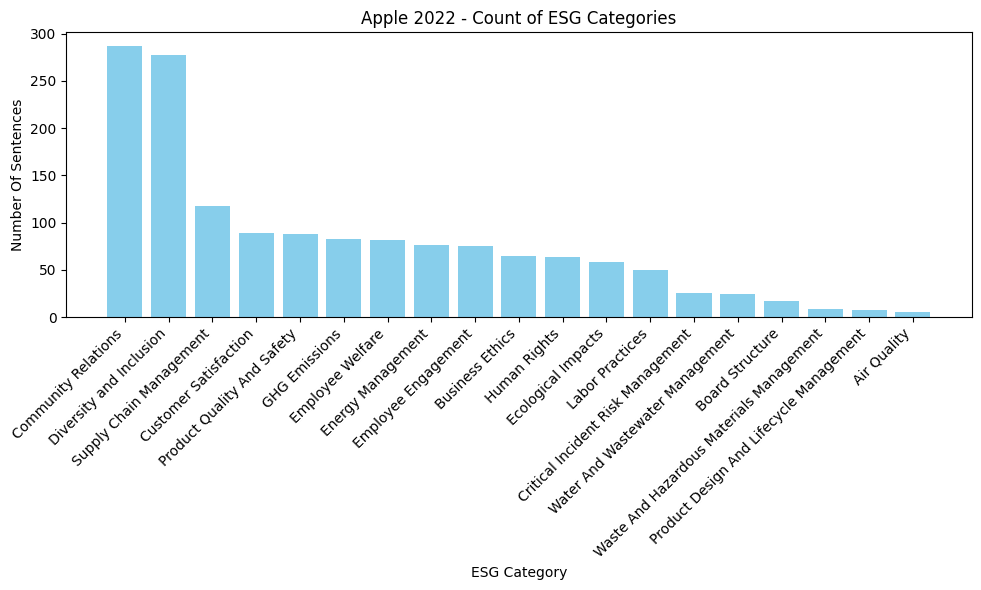

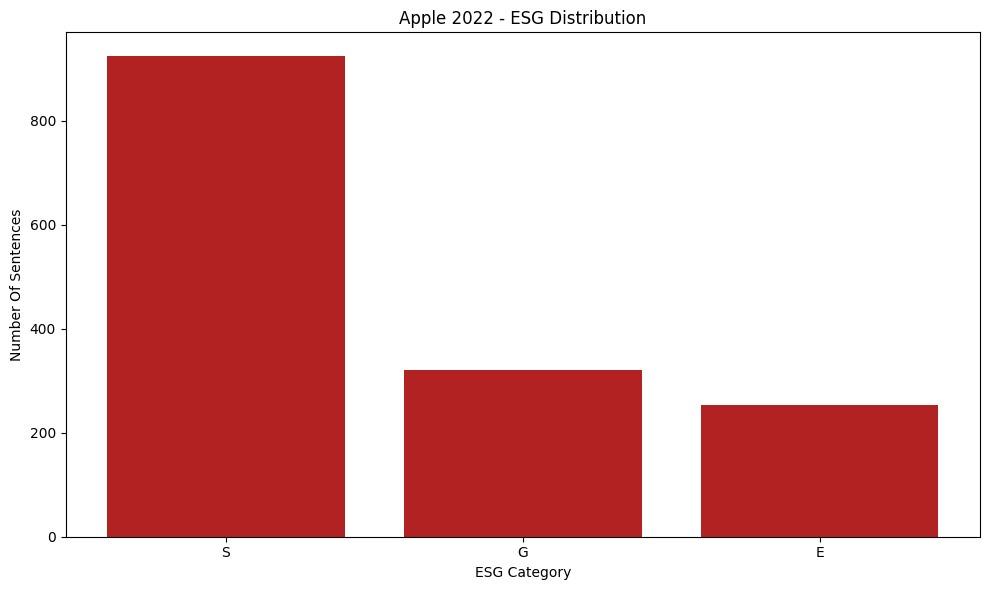

In [ ]:
plot_report(apple_2022_df, apple_name22_label, apple_name22_esg)

***2021***

In [ ]:
apple_2021_df = analyze_report("""company,url
Apple_2021, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/a/NASDAQ_AAPL_2021.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
apple_2021_df.to_excel('apple_2021.xlsx')
files.download('apple_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name21_label = "Apple 2021 - Count of ESG Categories"
apple_name21_esg = "Apple 2021 - ESG Distribution"

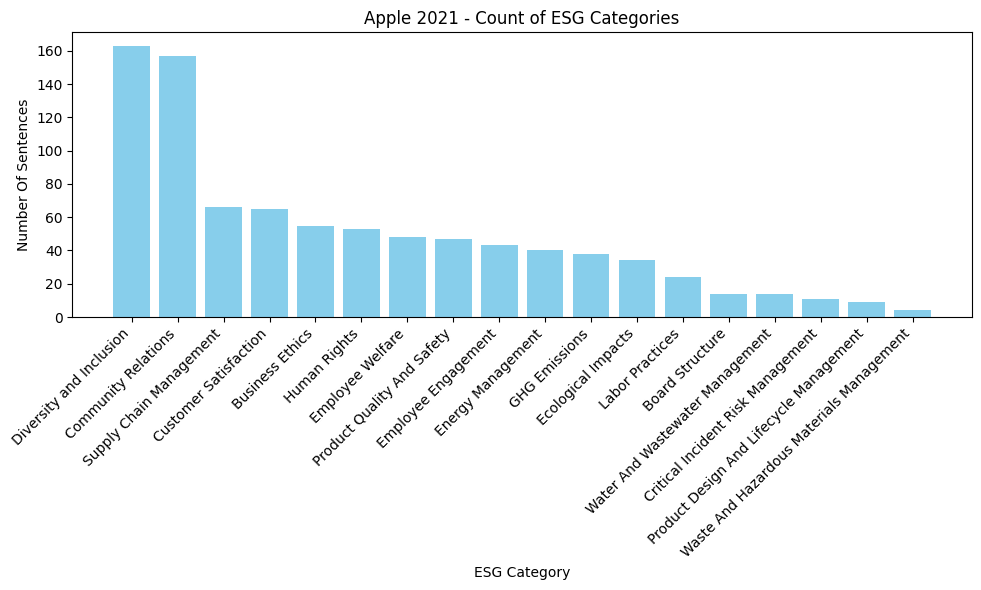

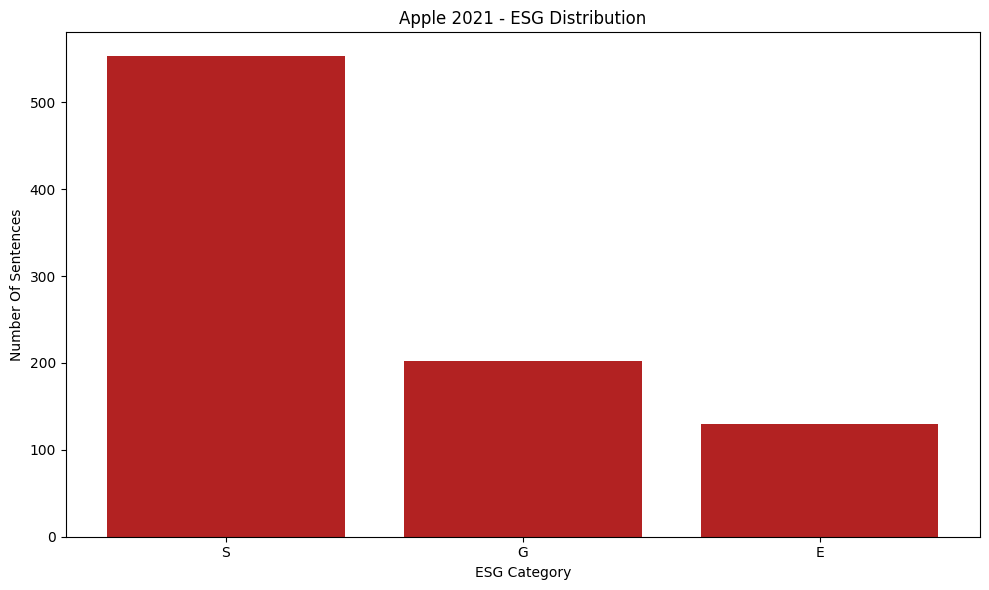

In [ ]:
plot_report(apple_2021_df, apple_name21_label, apple_name21_esg)

***2020***

In [ ]:
apple_2020_df = analyze_report("""company,url
Apple_2020, https://www.apple.com/environment/pdf/Apple_Environmental_Progress_Report_2020.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
apple_2020_df.to_excel('apple_2020.xlsx')
files.download('apple_2020.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name20_label = "Apple 2020 - Count of ESG Categories"
apple_name20_esg = "Apple 2020 - ESG Distribution"

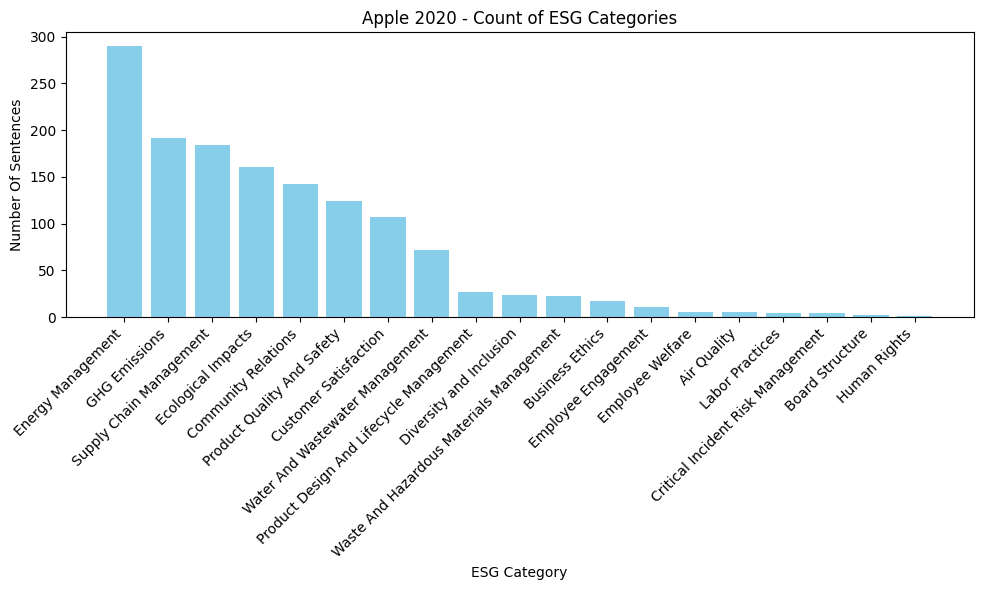

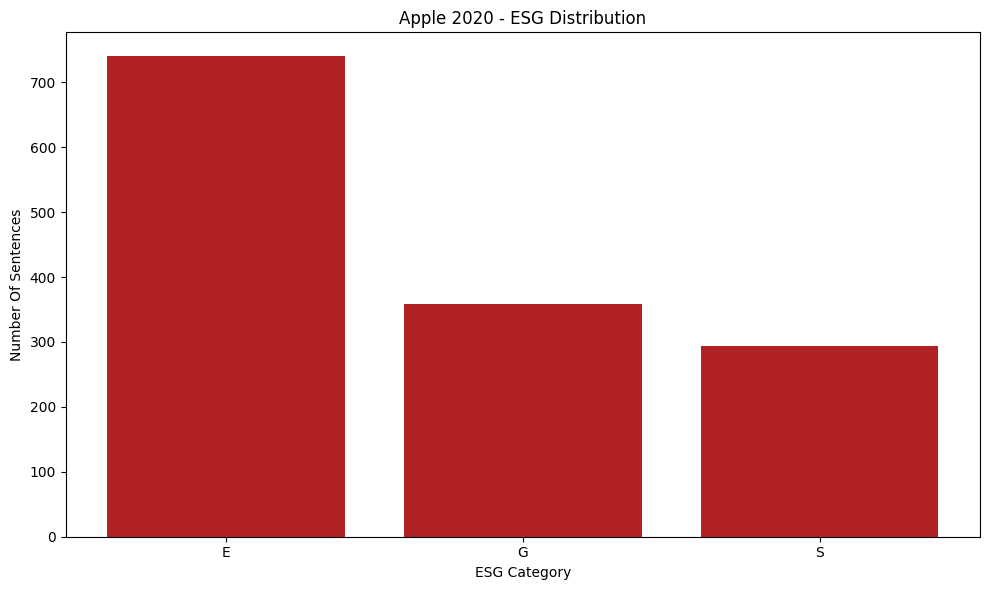

In [ ]:
plot_report(apple_2020_df, apple_name20_label, apple_name20_esg)

***2019***

In [ ]:
apple_2019_df = analyze_report("""company,url
Apple_2019, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/a/NASDAQ_AAPL_2019.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
apple_2019_df.to_excel('apple_2019.xlsx')
files.download('apple_2019.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name19_label = "Apple 2019 - Count of ESG Categories"
apple_name19_esg = "Apple 2019 - ESG Distribution"

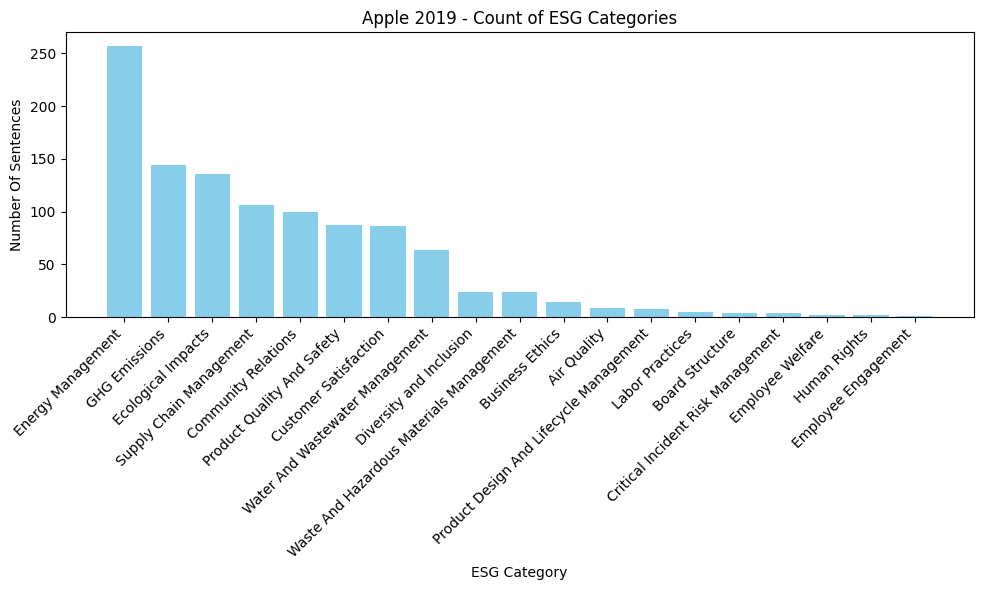

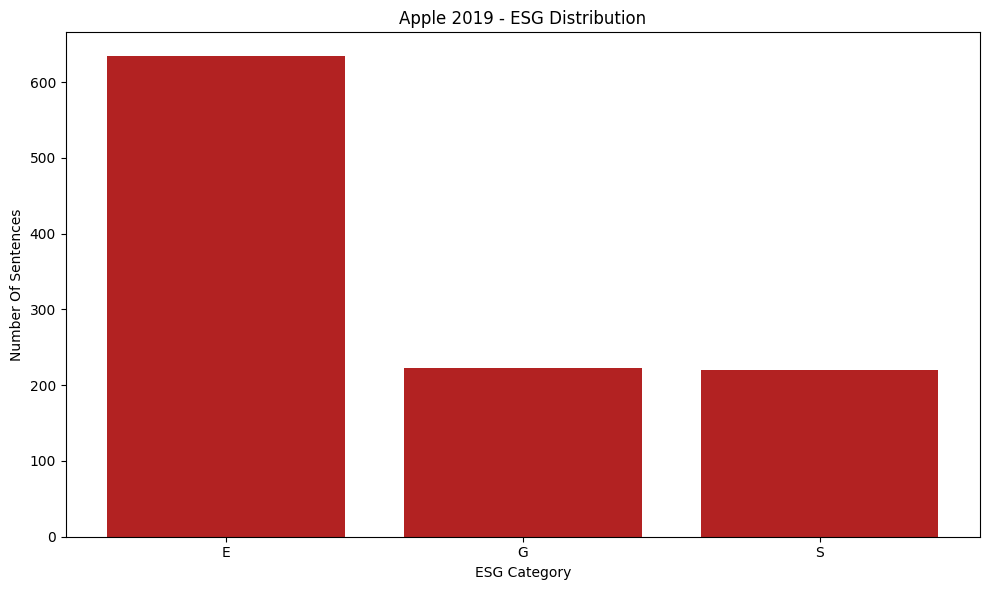

In [ ]:
plot_report(apple_2019_df, apple_name19_label, apple_name19_esg)

***2018***

In [ ]:
apple_2018_df = analyze_report("""company,url
Apple_2018, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/a/NASDAQ_AAPL_2018.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
apple_2018_df.to_excel('apple_2018.xlsx')
files.download('apple_2018.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
apple_name18_label = "Apple 2018 - Count of ESG Categories"
apple_name18_esg = "Apple 2018 - ESG Distribution"

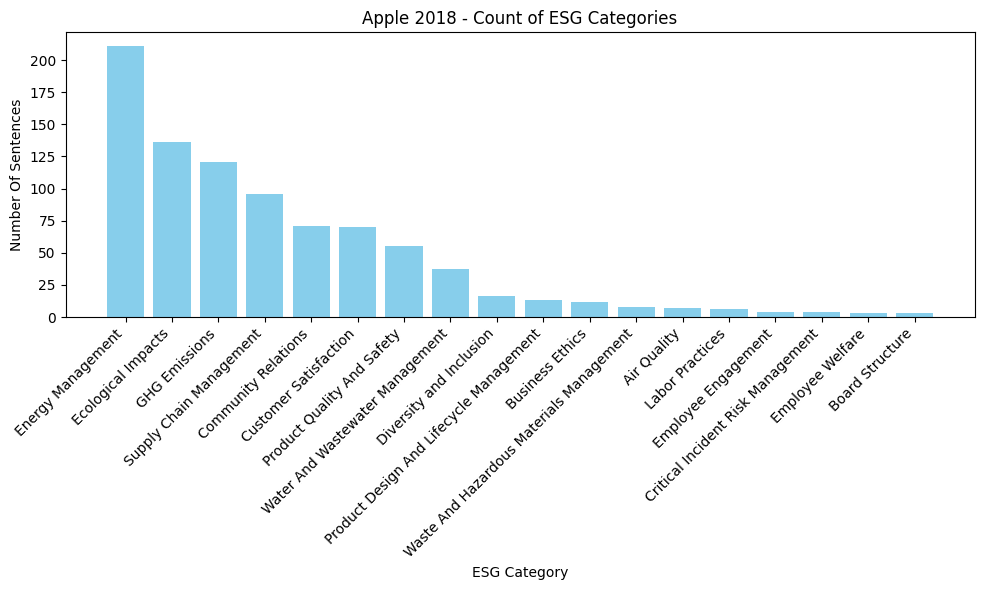

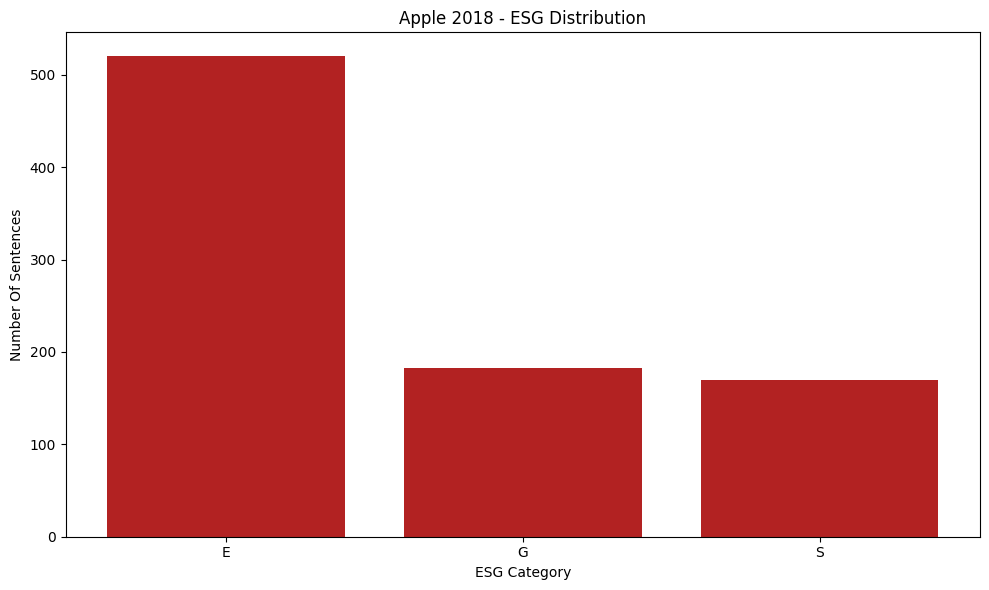

In [ ]:
plot_report(apple_2018_df, apple_name18_label, apple_name18_esg)

***Comparison***

In [ ]:
apple_2022_df_id = count_id(apple_2022_df)
apple_2021_df_id = count_id(apple_2021_df)
apple_2020_df_id = count_id(apple_2020_df)
apple_2019_df_id = count_id(apple_2019_df)
apple_2018_df_id = count_id(apple_2018_df)

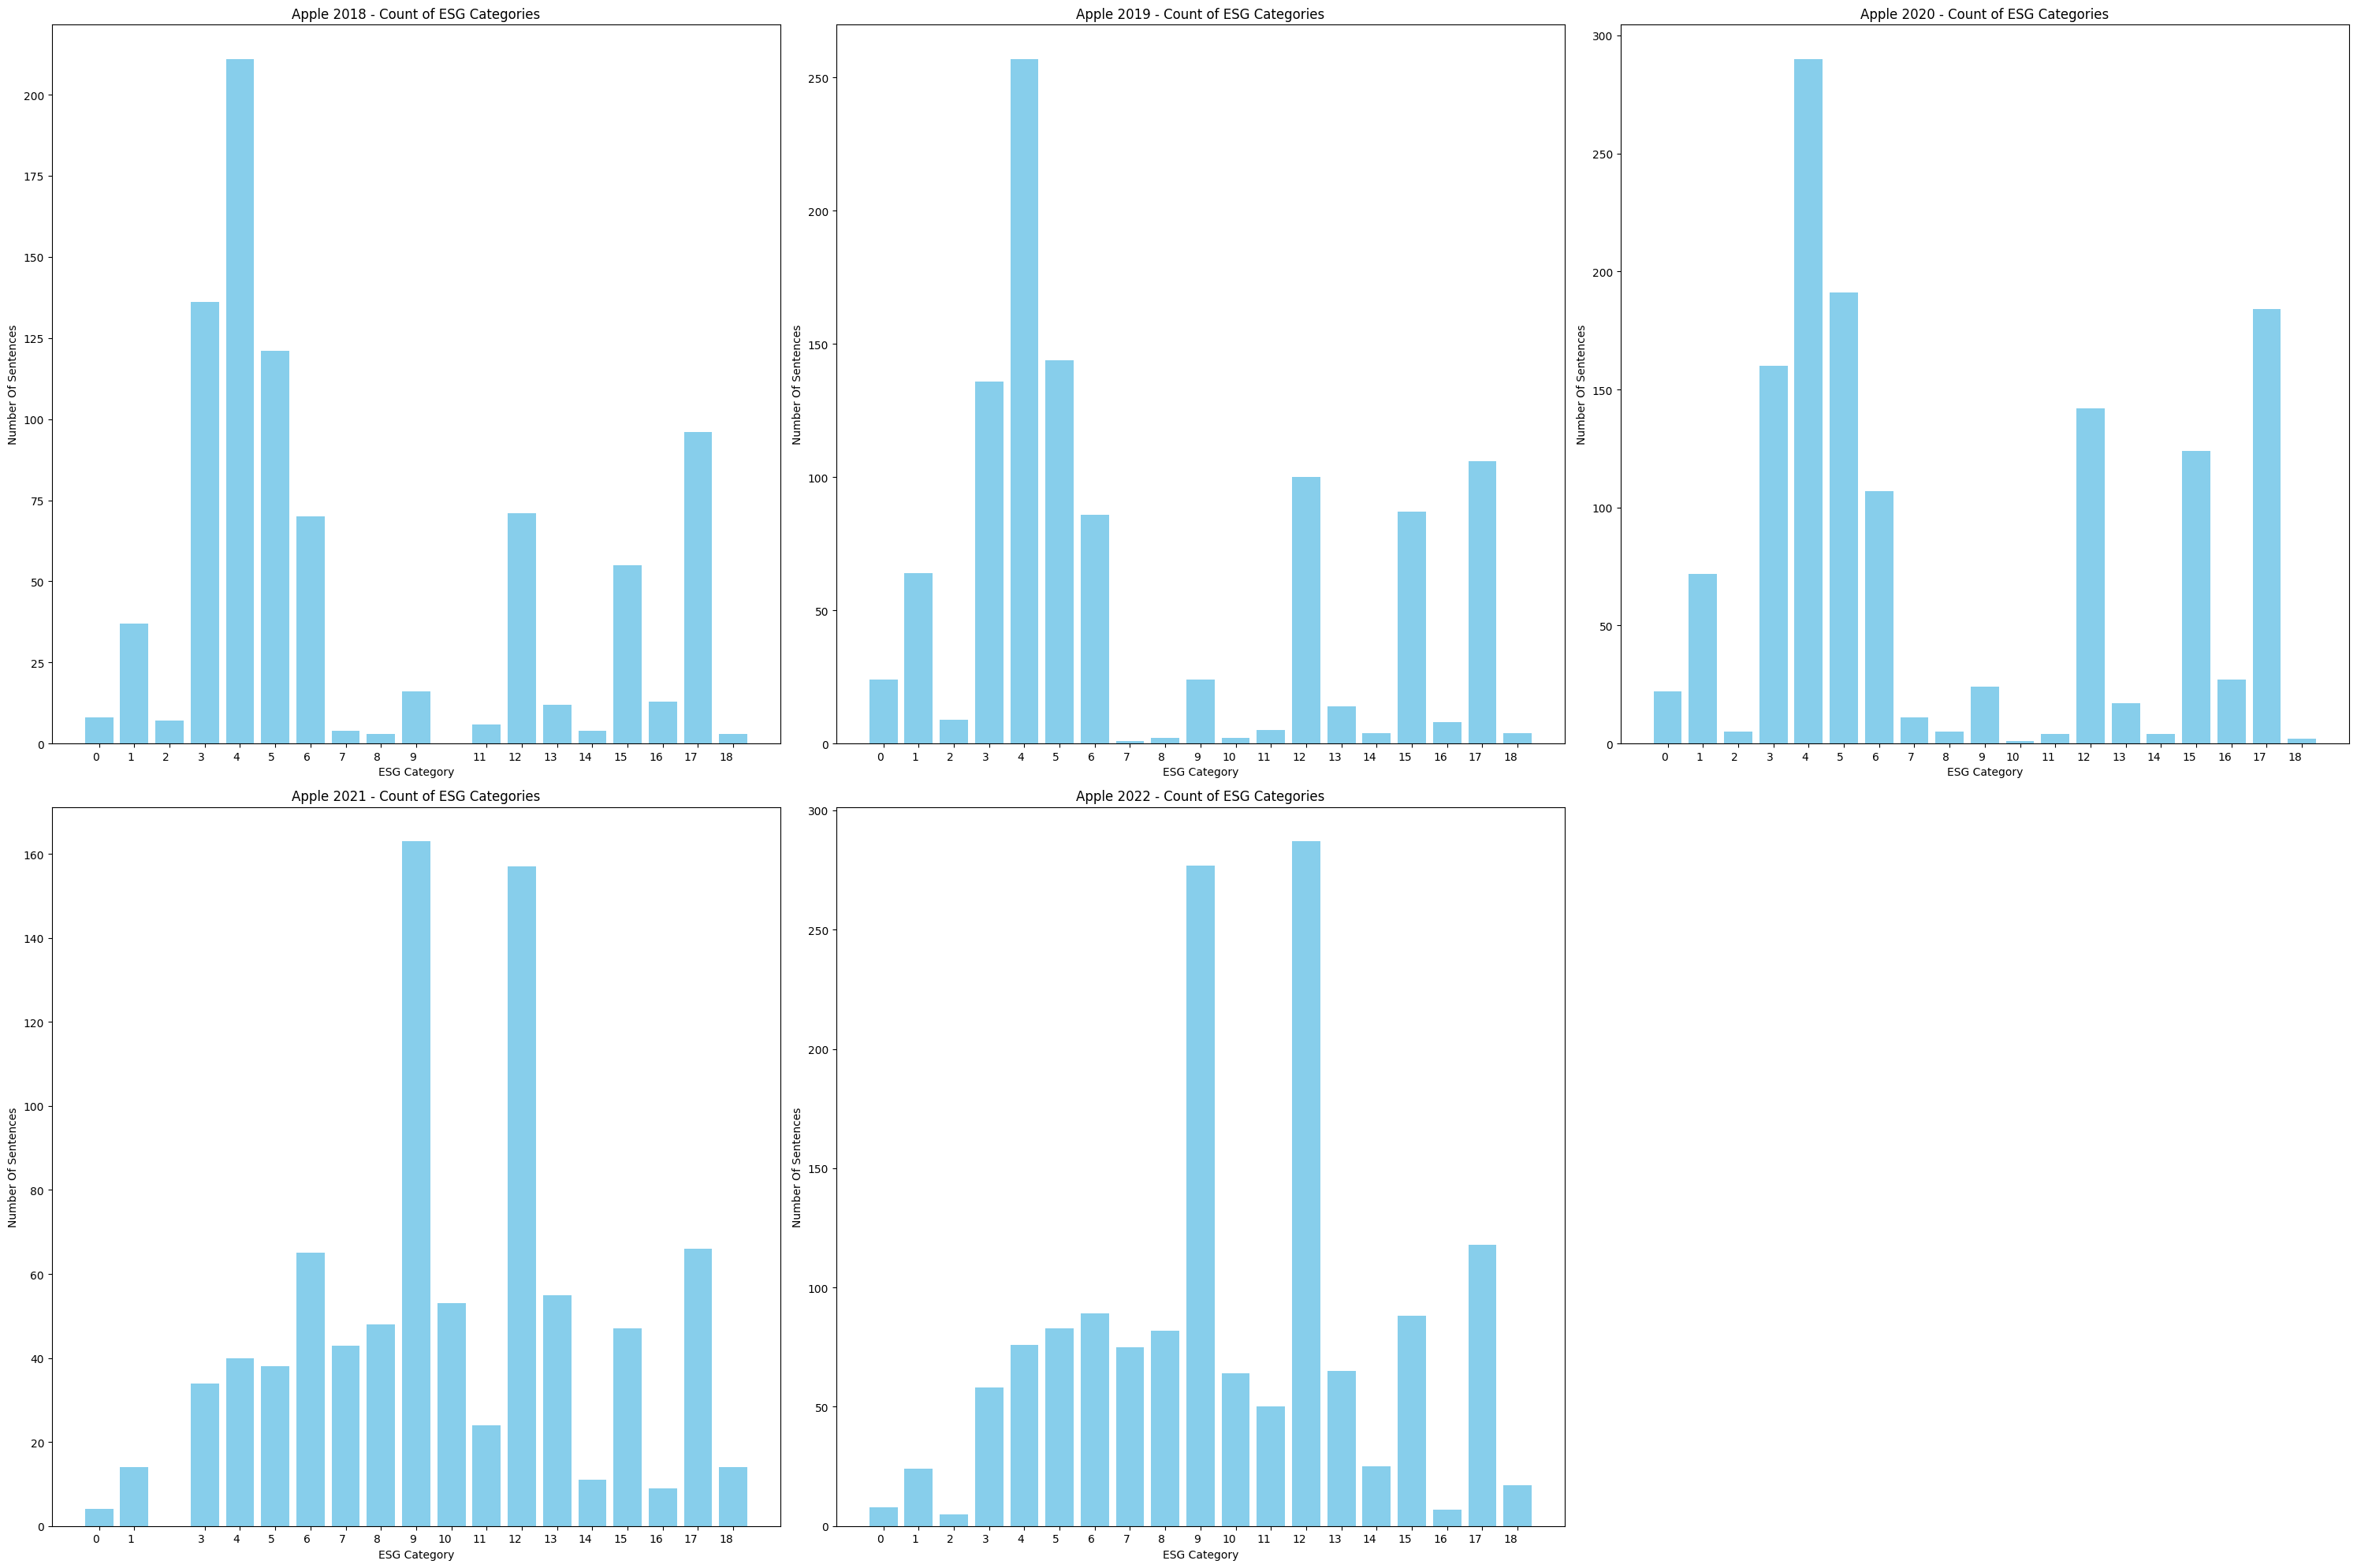

In [ ]:
plot_all(apple_2022_df_id, apple_name22_label, apple_2021_df_id, apple_name21_label, apple_2020_df_id, apple_name20_label, apple_2019_df_id, apple_name19_label, apple_2018_df_id, apple_name18_label)





# **Walmart**


---



***2022***

In [ ]:
walmart_2022_df = analyze_report("""company,url
Walmart_2022, https://corporate.walmart.com/esgreport/media-library/document/walmart-fy2022-esg-summary/_proxyDocument?id=00000182-21ec-d591-afe2-2bfcb4df0000""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
walmart_2022_df.to_excel('walmart_2022.xlsx')
files.download('walmart_2022.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name22_label = "Walmart 2022 - Count of ESG Categories"
walmart_name22_esg = "Walmart 2022 - ESG Distribution"

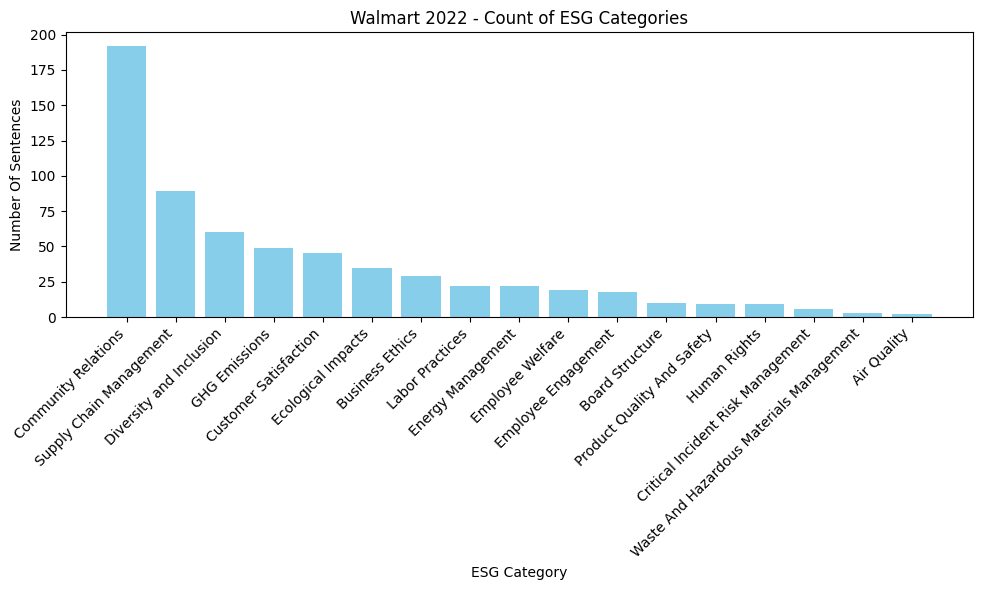

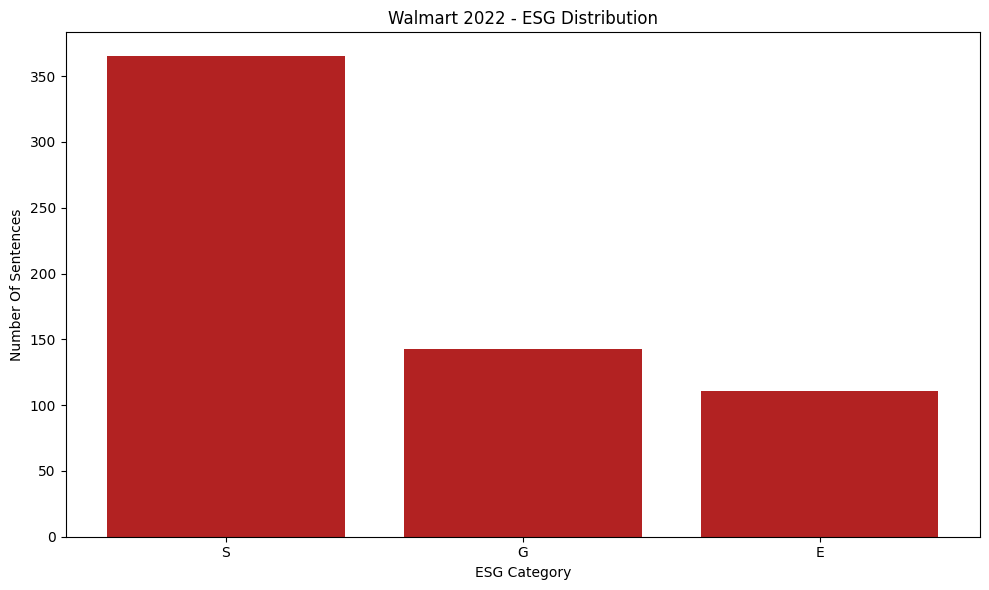

In [ ]:
plot_report(walmart_2022_df, walmart_name22_label, walmart_name22_esg)

***2021***

In [ ]:
walmart_2021_df = analyze_report("""company,url
Walmart_2021, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/w/NYSE_WMT_2021_3036d8b69ebe45ae9bc770a7b99a8a8b.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
walmart_2021_df.to_excel('walmart_2021.xlsx')
files.download('walmart_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name21_label = "Walmart 2021 - Count of ESG Categories"
walmart_name21_esg = "Walmart 2021 - ESG Distribution"

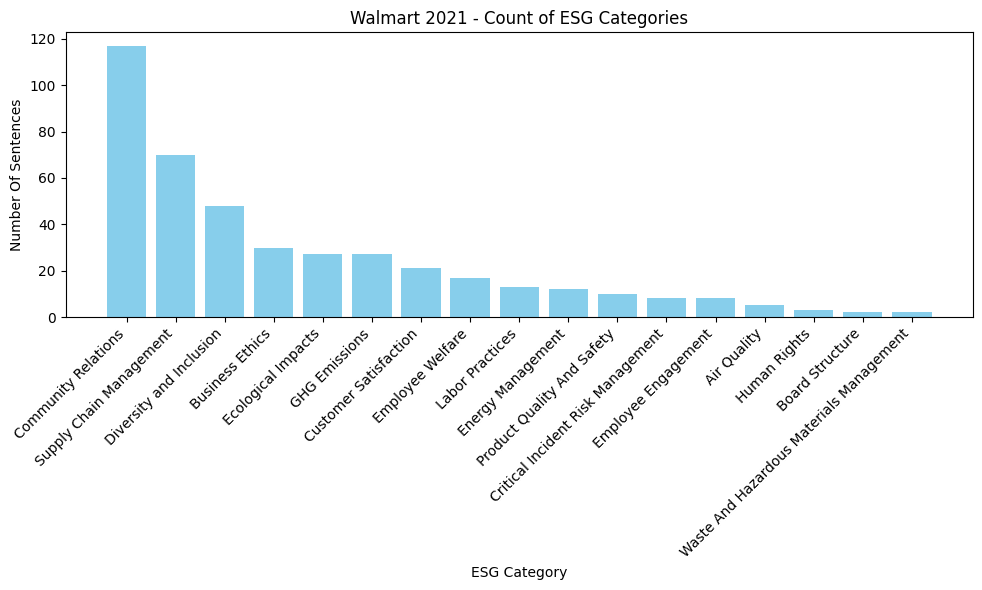

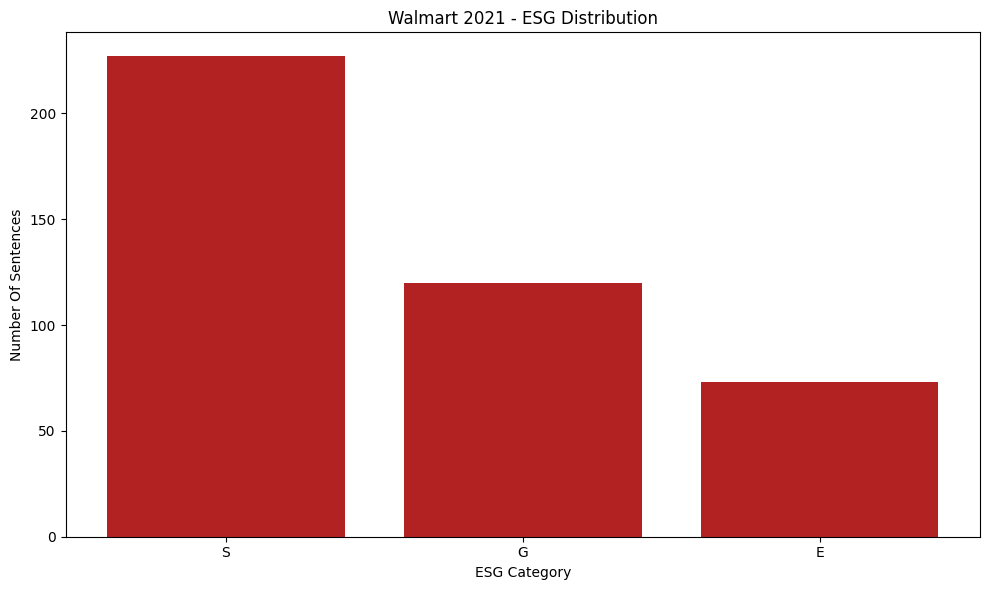

In [ ]:
plot_report(walmart_2021_df, walmart_name21_label, walmart_name21_esg)

***2020***

In [ ]:
walmart_2020_df = analyze_report("""company,url
Walmart_2020, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/w/NYSE_WMT_2020_68e82aaa21eb452ea09e7e5f53d0472f.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
walmart_2020_df.to_excel('walmart_2020.xlsx')
files.download('walmart_2020.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name20_label = "Walmart 2020 - Count of ESG Categories"
walmart_name20_esg = "Walmart 2020 - ESG Distribution"

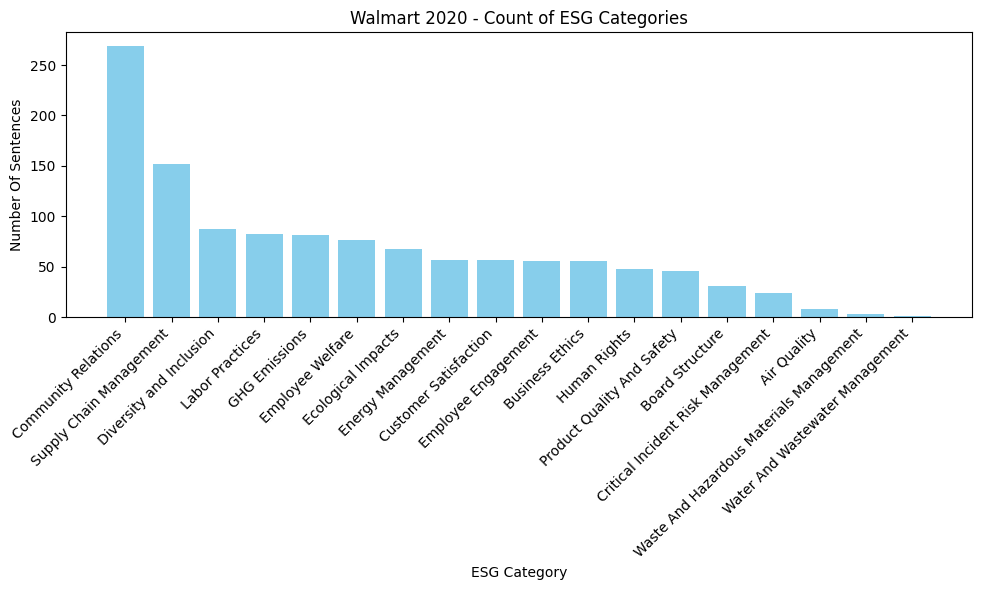

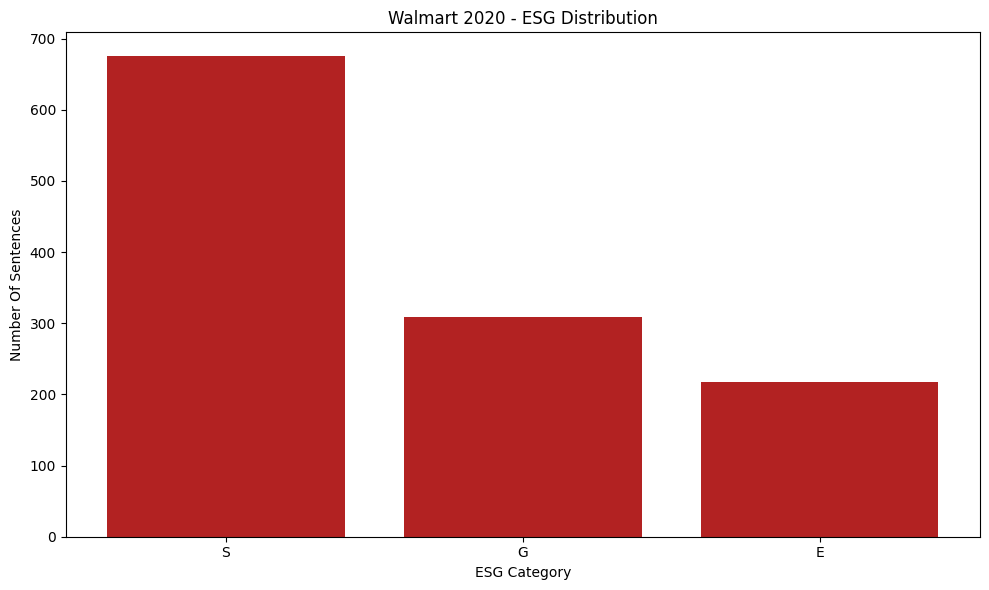

In [ ]:
plot_report(walmart_2020_df, walmart_name20_label, walmart_name20_esg)

***2019***

In [ ]:
walmart_2019_df = analyze_report("""company,url
Walmart_2019, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/w/NYSE_WMT_2019.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
walmart_2019_df.to_excel('walmart_2019.xlsx')
files.download('walmart_2019.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name19_label = "Walmart 2019 - Count of ESG Categories"
walmart_name19_esg = "Walmart 2019 - ESG Distribution"

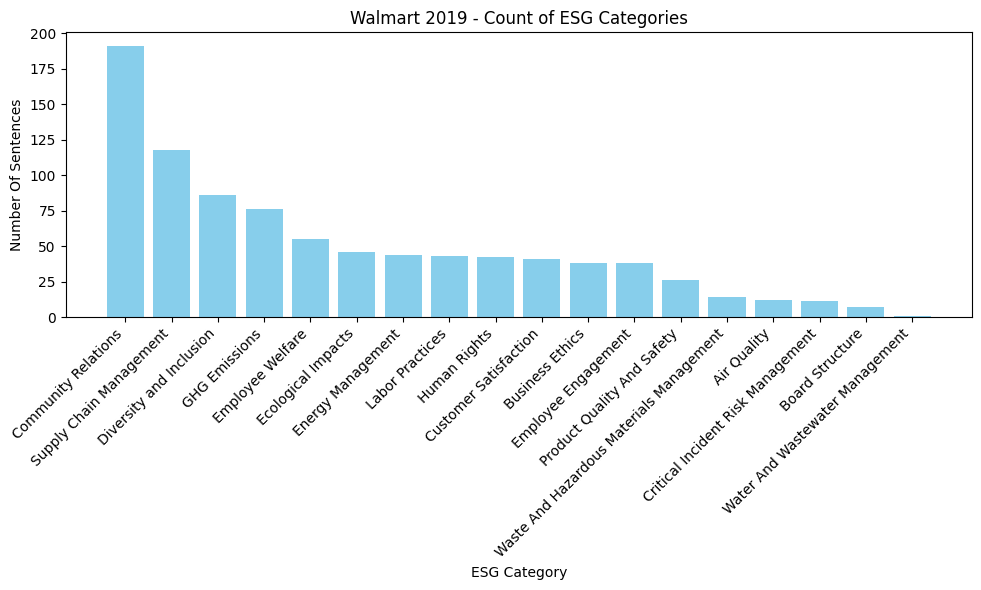

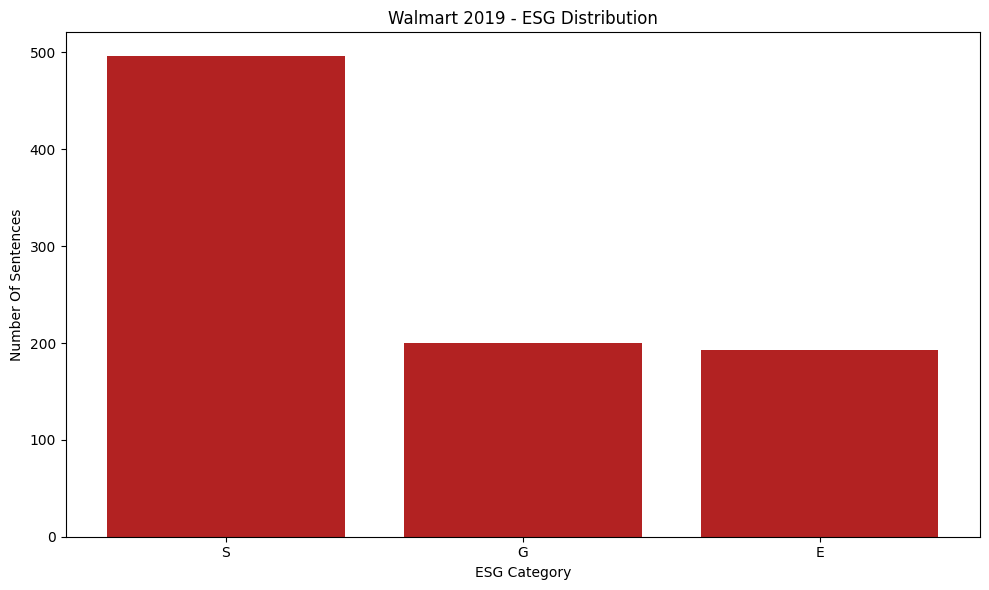

In [ ]:
plot_report(walmart_2019_df, walmart_name19_label, walmart_name19_esg)

***2018***

In [ ]:
walmart_2018_df = analyze_report("""company,url
Walmart_2018, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/w/NYSE_WMT_2018_093758797bbc4cdea3f1260f230776b9.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
walmart_2018_df.to_excel('walmart_2018.xlsx')
files.download('walmart_2018.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
walmart_name18_label = "Walmart 2018 - Count of ESG Categories"
walmart_name18_esg = "Walmart 2018 - ESG Distribution"

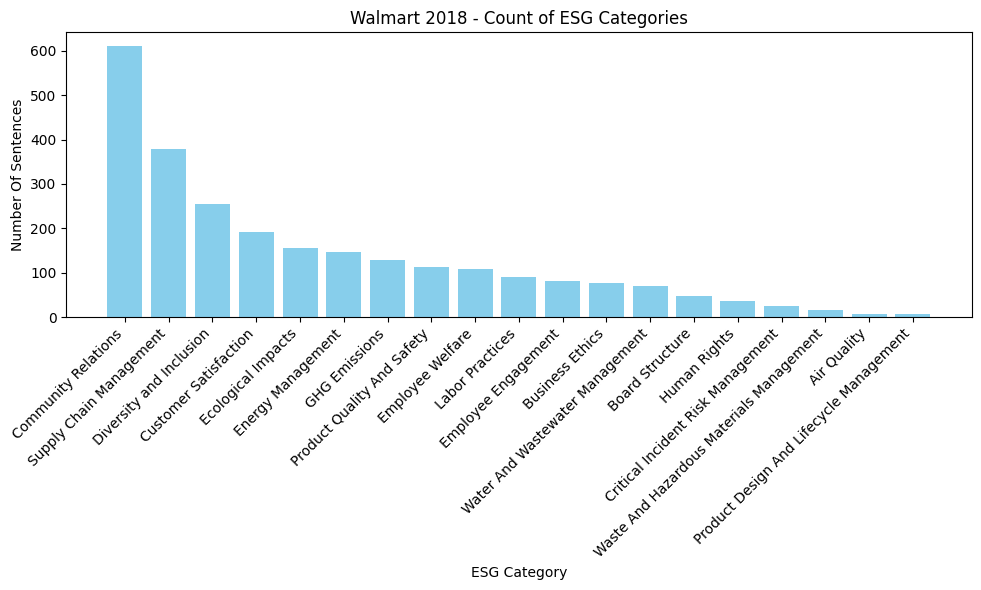

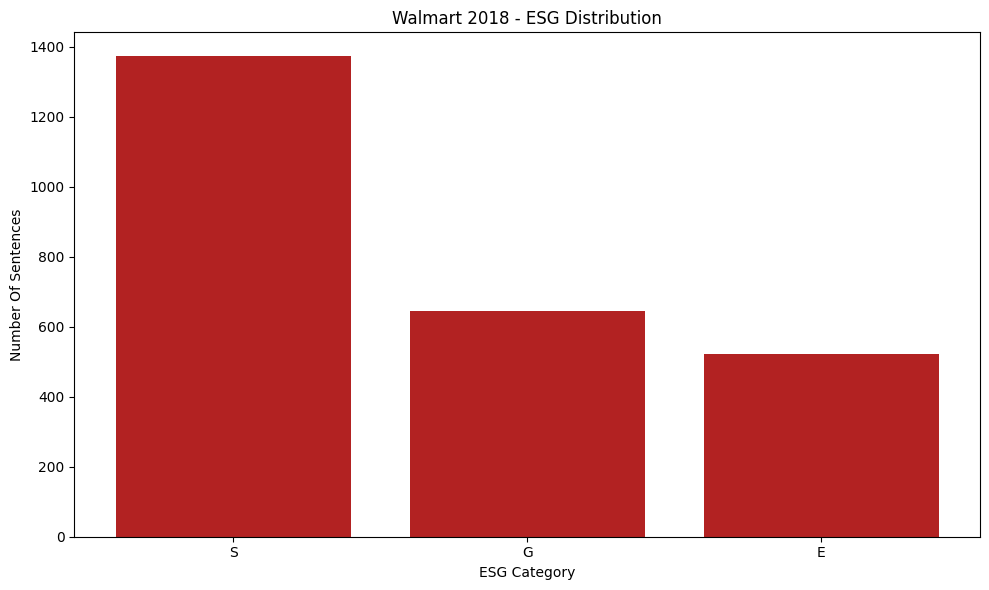

In [ ]:
plot_report(walmart_2018_df, walmart_name18_label, walmart_name18_esg)

***Comparison***

In [ ]:
walmart_2022_df_id = count_id(walmart_2022_df)
walmart_2021_df_id = count_id(walmart_2021_df)
walmart_2020_df_id = count_id(walmart_2020_df)
walmart_2019_df_id = count_id(walmart_2019_df)
walmart_2018_df_id = count_id(walmart_2018_df)

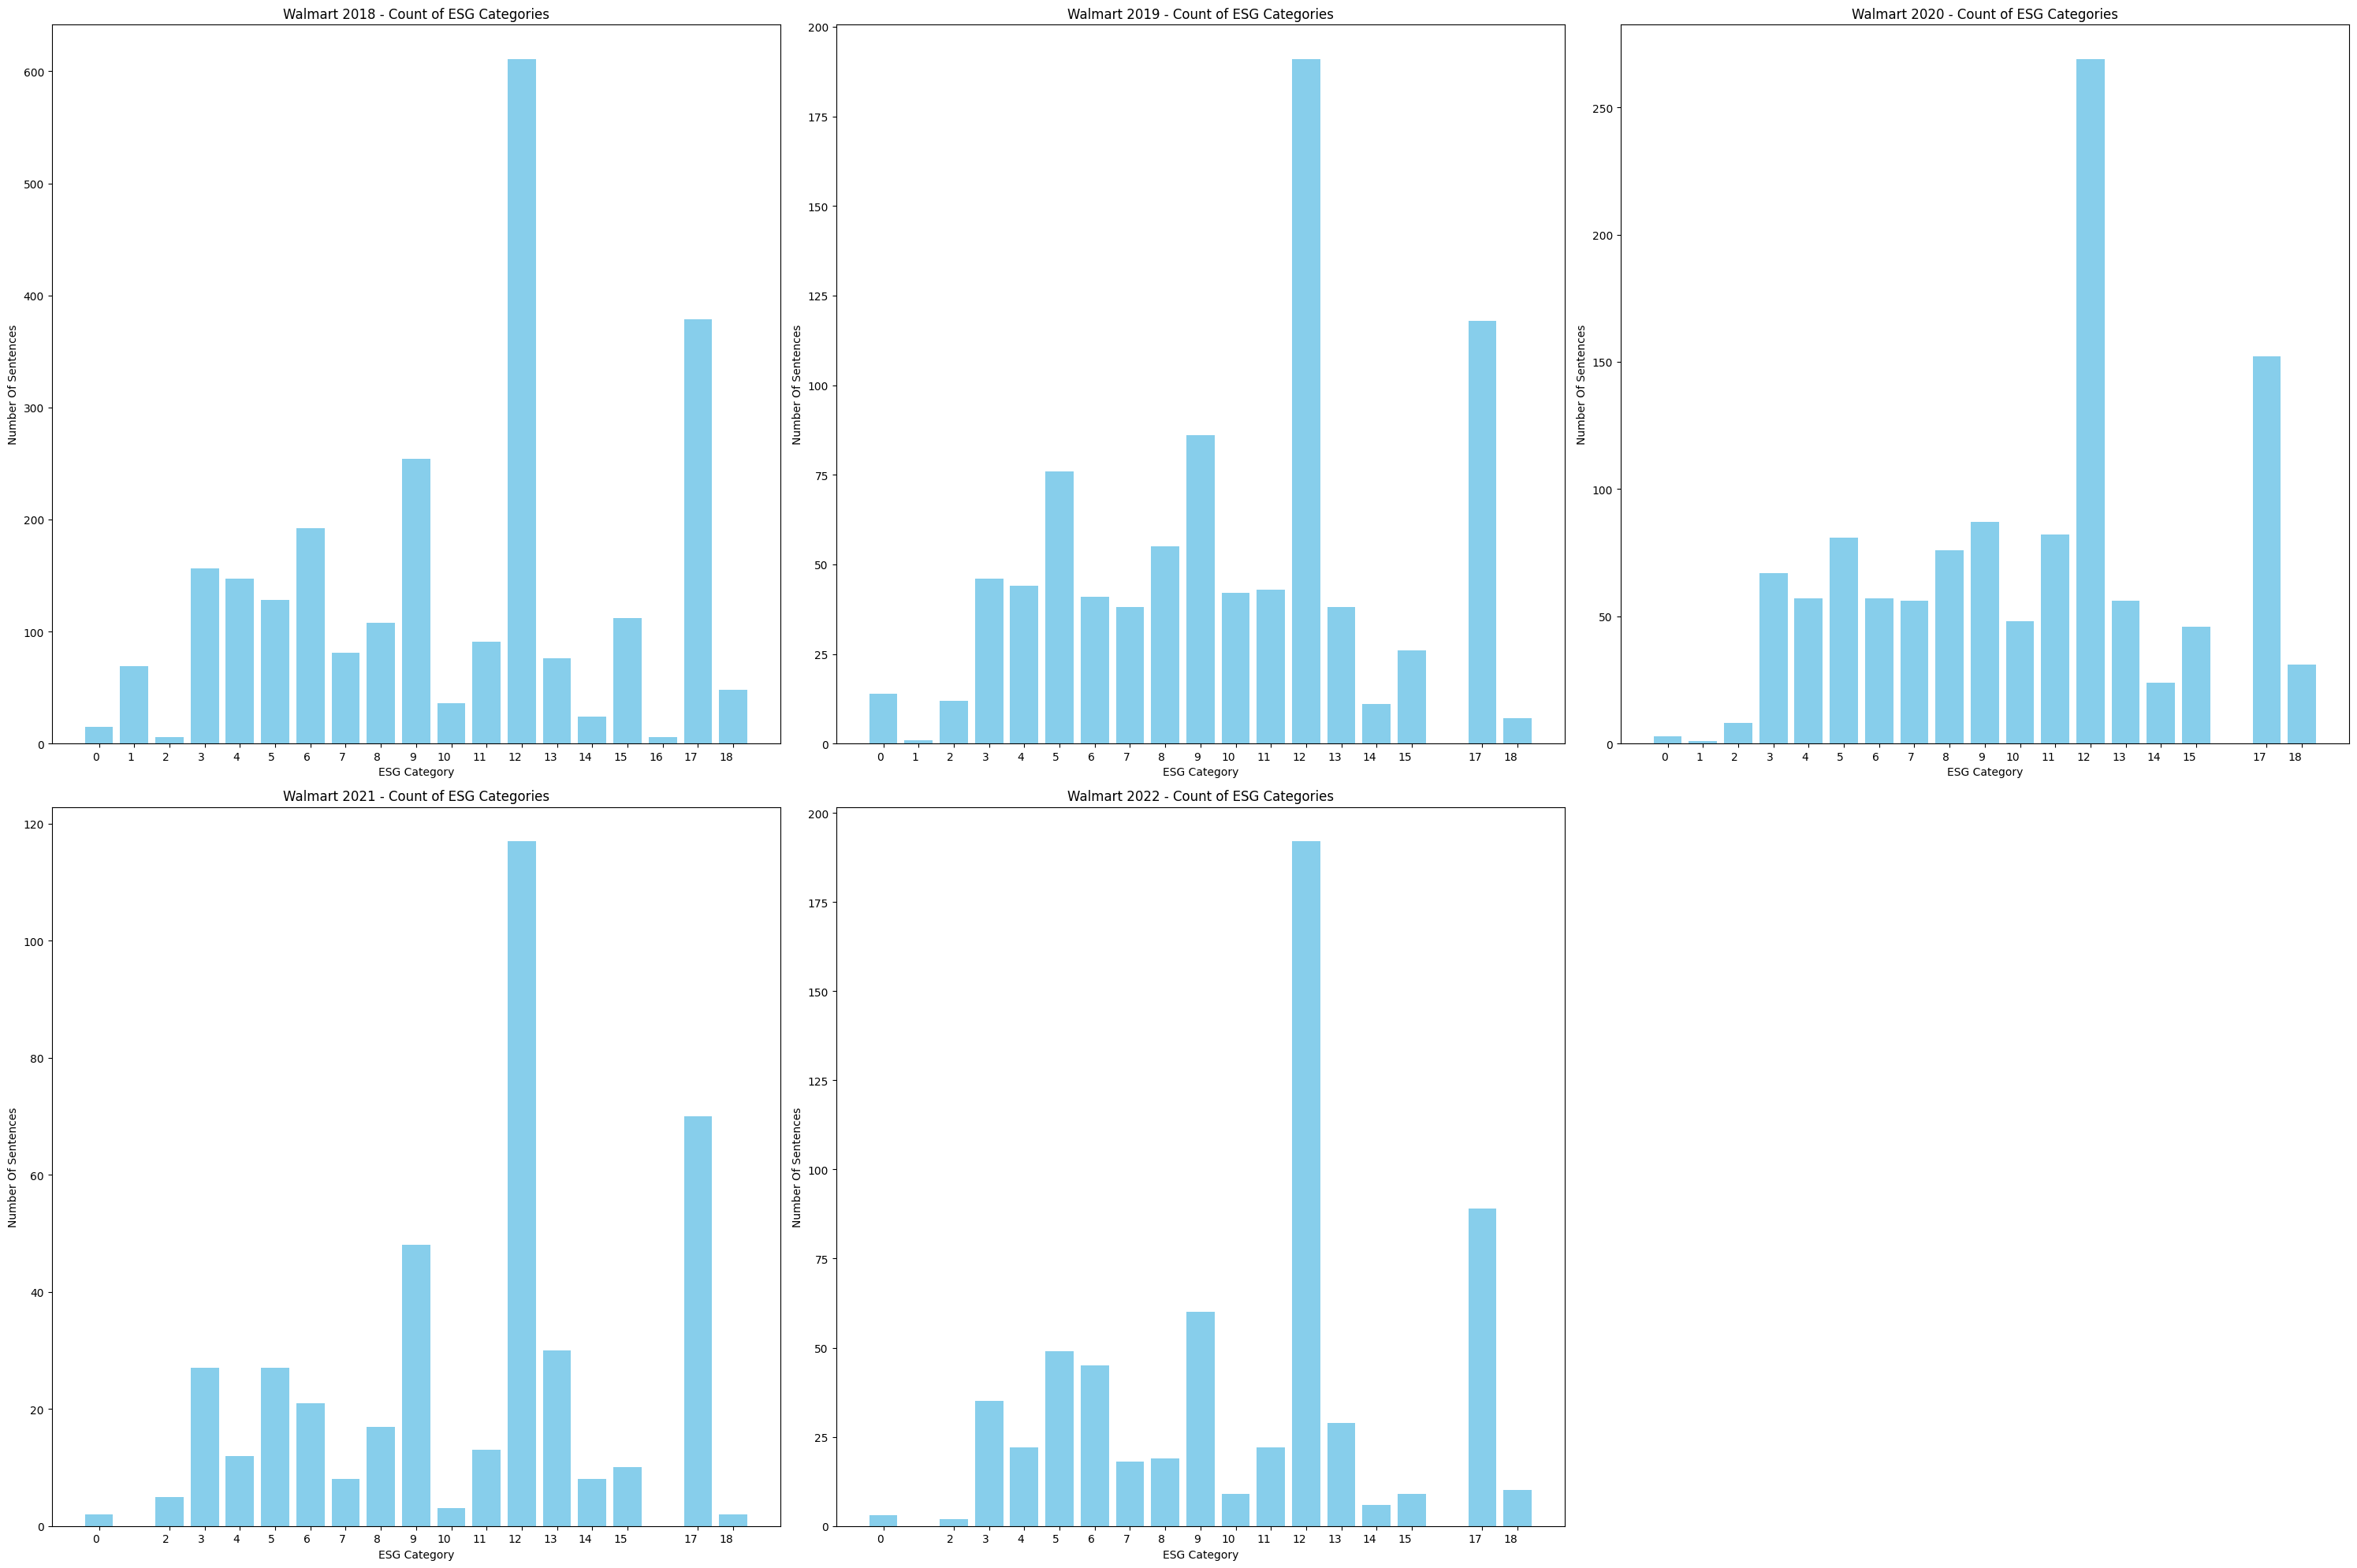

In [ ]:
plot_all(walmart_2022_df_id, walmart_name22_label, walmart_2021_df_id, walmart_name21_label, walmart_2020_df_id, walmart_name20_label, walmart_2019_df_id, walmart_name19_label, walmart_2018_df_id, walmart_name18_label)





# **Chevron**


---



 ***2022***

In [ ]:
chevron_2022_df = analyze_report("""company,url
Chevron_2022, https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_CVX_2022.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
chevron_2022_df.to_excel('chevron_2022.xlsx')
files.download('chevron_2022.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name22_label = "Chevron 2022 - Count of ESG Categories"
chevron_name22_esg = "Chevron 2022 - ESG Distribution"

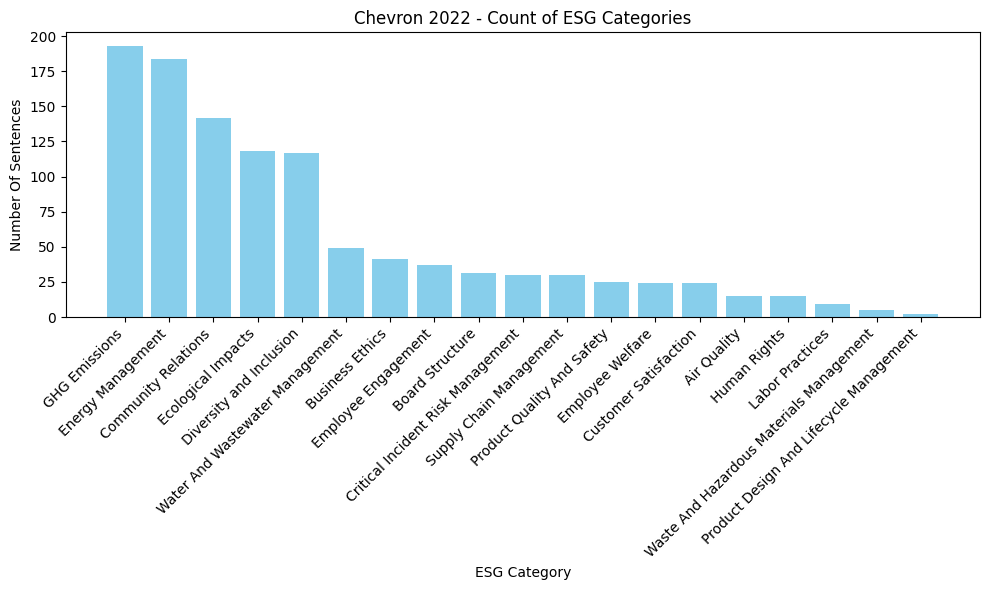

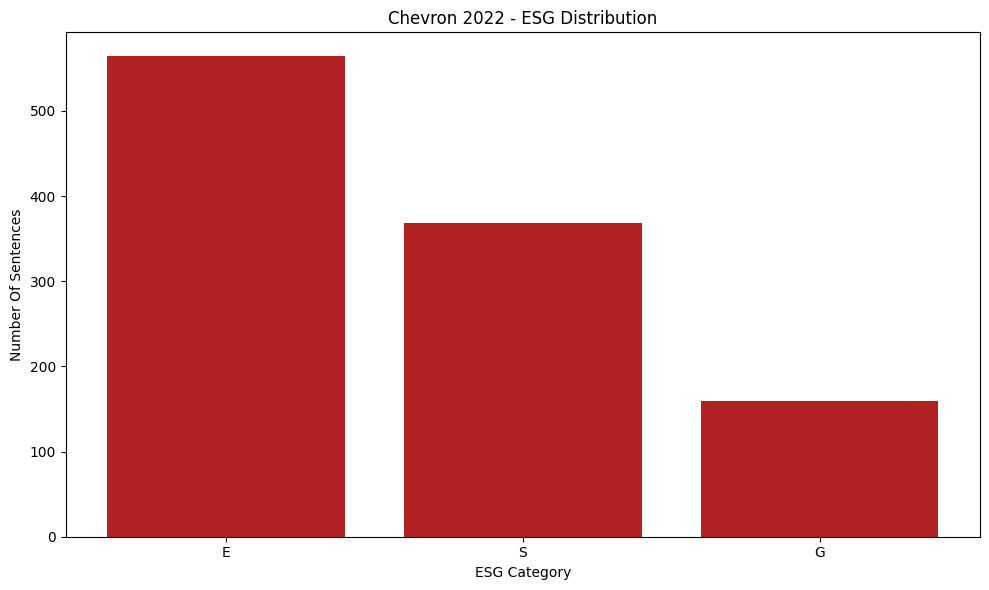

In [ ]:
plot_report(chevron_2022_df, chevron_name22_label, chevron_name22_esg)

***2021***

In [ ]:
chevron_2021_df = analyze_report("""company,url
Chevron_2021, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/c/NYSE_CVX_2021.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
chevron_2021_df.to_excel('chevron_2021.xlsx')
files.download('chevron_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name21_label = "Chevron 2021 - Count of ESG Categories"
chevron_name21_esg = "Chevron 2021 - ESG Distribution"

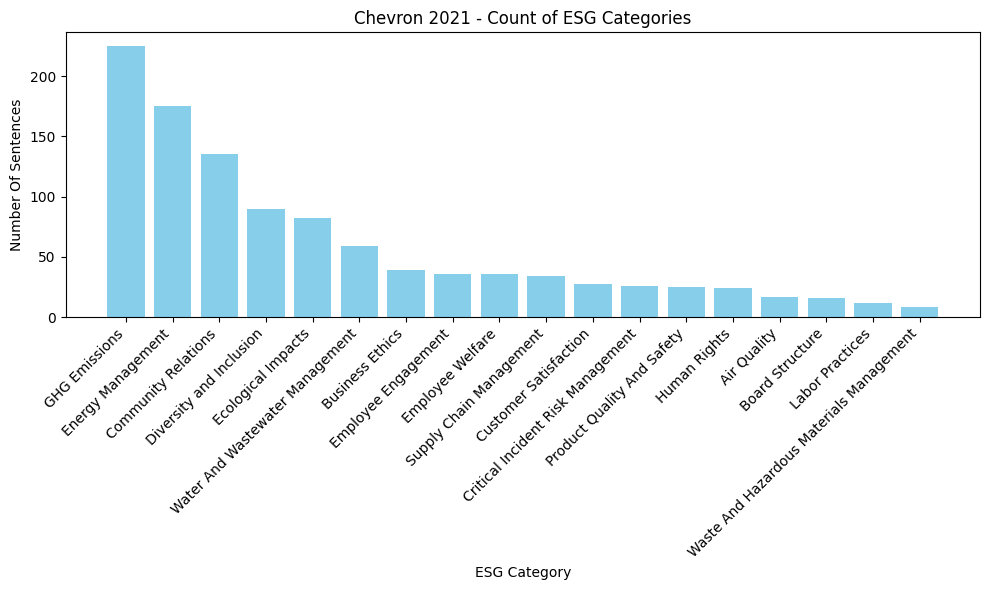

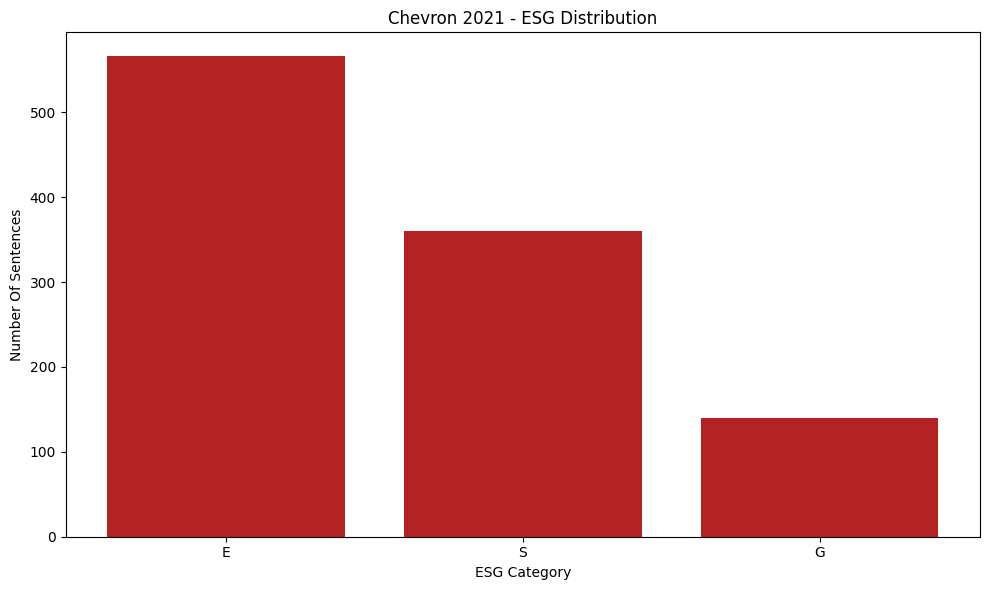

In [ ]:
plot_report(chevron_2021_df, chevron_name21_label, chevron_name21_esg)

***2020***

In [ ]:
chevron_2020_df = analyze_report("""company,url
Chevron_2020, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/c/NYSE_CVX_2020.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
chevron_2020_df.to_excel('chevron_2020.xlsx')
files.download('chevron_2020.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name20_label = "Chevron 2020 - Count of ESG Categories"
chevron_name20_esg = "Chevron 2020 - ESG Distribution"

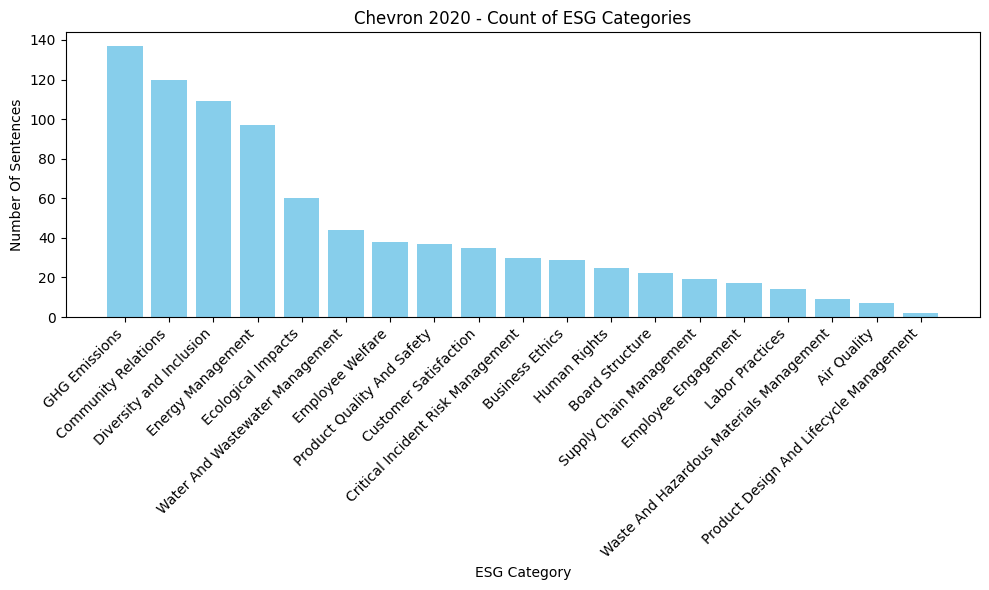

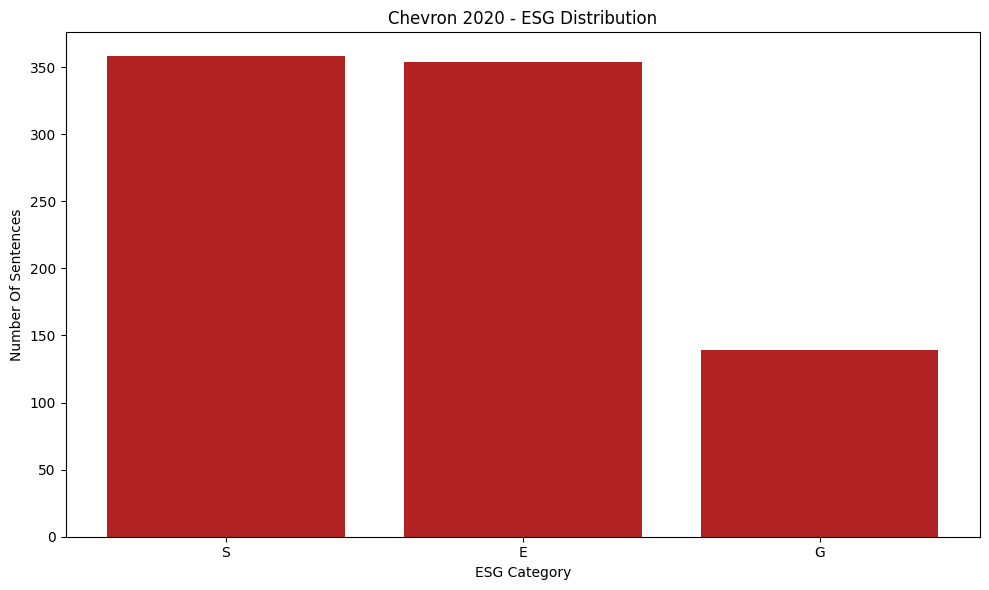

In [ ]:
plot_report(chevron_2020_df, chevron_name20_label, chevron_name20_esg)

***2019***

In [ ]:
chevron_2019_df = analyze_report("""company,url
Chevron_2019, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/c/NYSE_CVX_2019.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
chevron_2019_df.to_excel('chevron_2019.xlsx')
files.download('chevron_2019.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name19_label = "Chevron 2019 - Count of ESG Categories"
chevron_name19_esg = "Chevron 2019 - ESG Distribution"

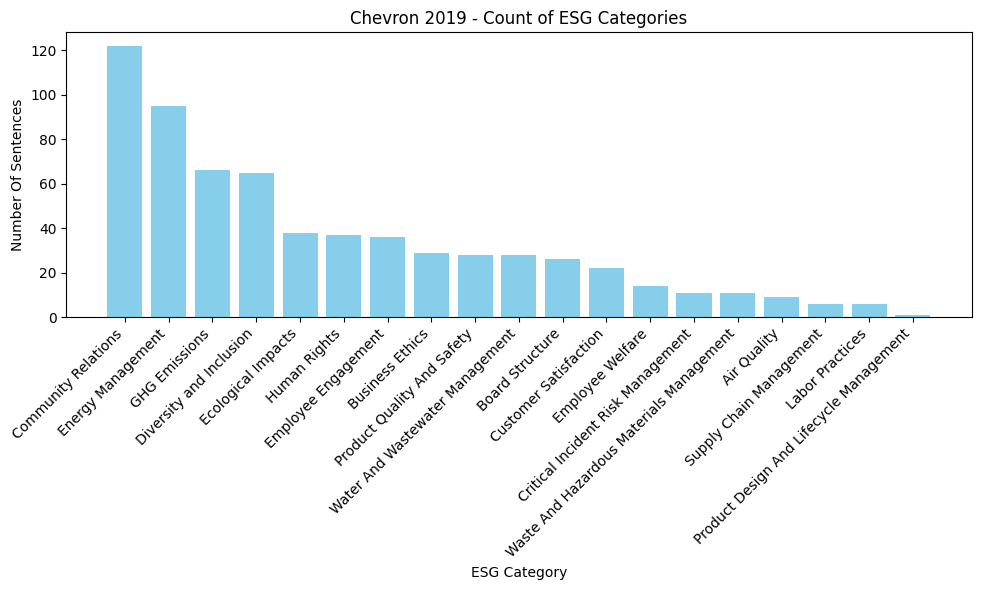

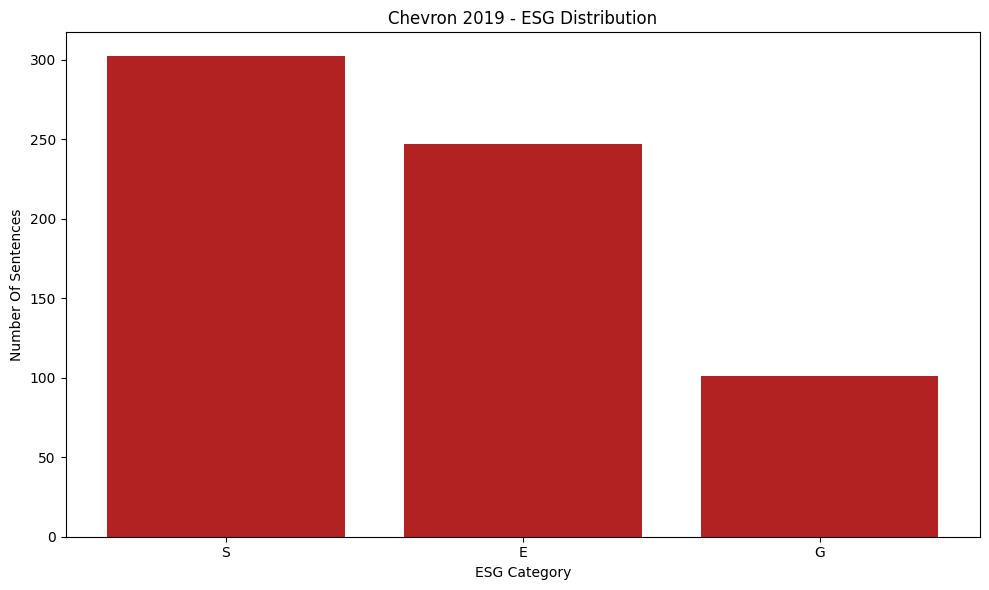

In [ ]:
plot_report(chevron_2019_df, chevron_name19_label, chevron_name19_esg)

***2018***

In [ ]:
chevron_2018_df = analyze_report("""company,url
Chevron_2018, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/c/NYSE_CVX_2018.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
chevron_2018_df.to_excel('chevron_2018.xlsx')
files.download('chevron_2018.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
chevron_name18_label = "Chevron 2018 - Count of ESG Categories"
chevron_name18_esg = "Chevron 2018 - ESG Distribution"

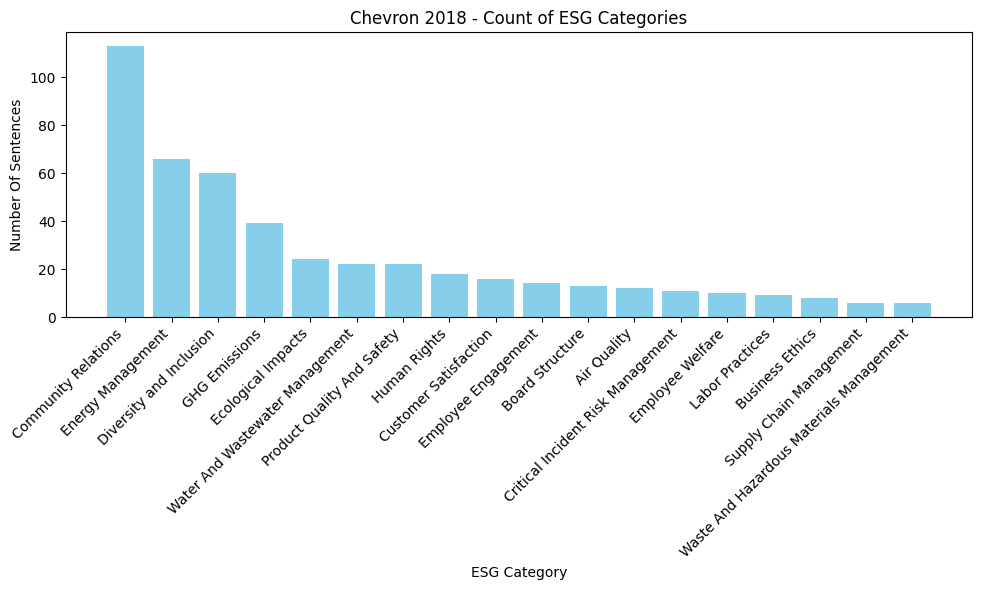

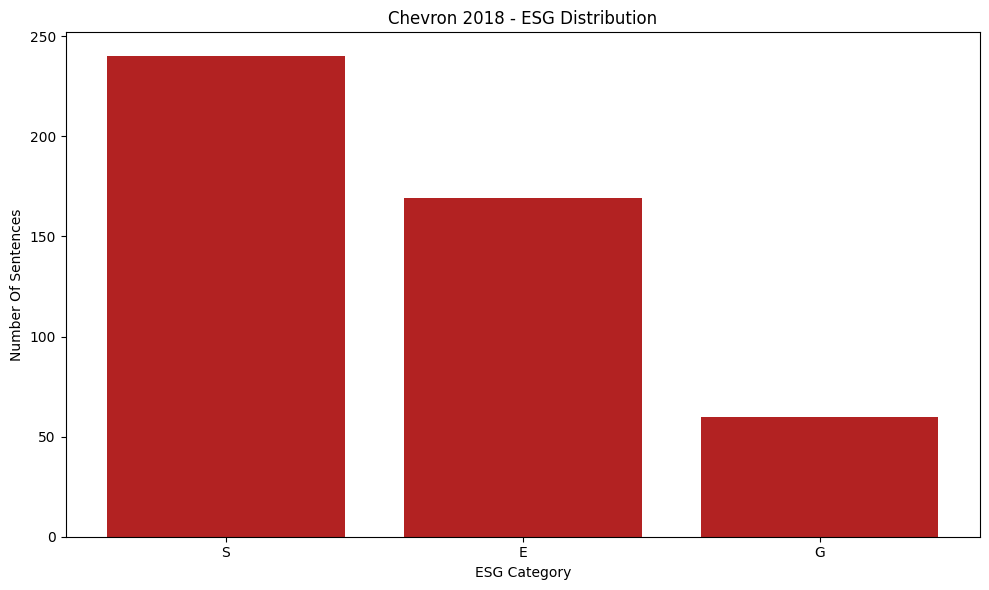

In [ ]:
plot_report(chevron_2018_df, chevron_name18_label, chevron_name18_esg)

***Comparison***

In [ ]:
chevron_2022_df_id = count_id(chevron_2022_df)
chevron_2021_df_id = count_id(chevron_2021_df)
chevron_2020_df_id = count_id(chevron_2020_df)
chevron_2019_df_id = count_id(chevron_2019_df)
chevron_2018_df_id = count_id(chevron_2018_df)

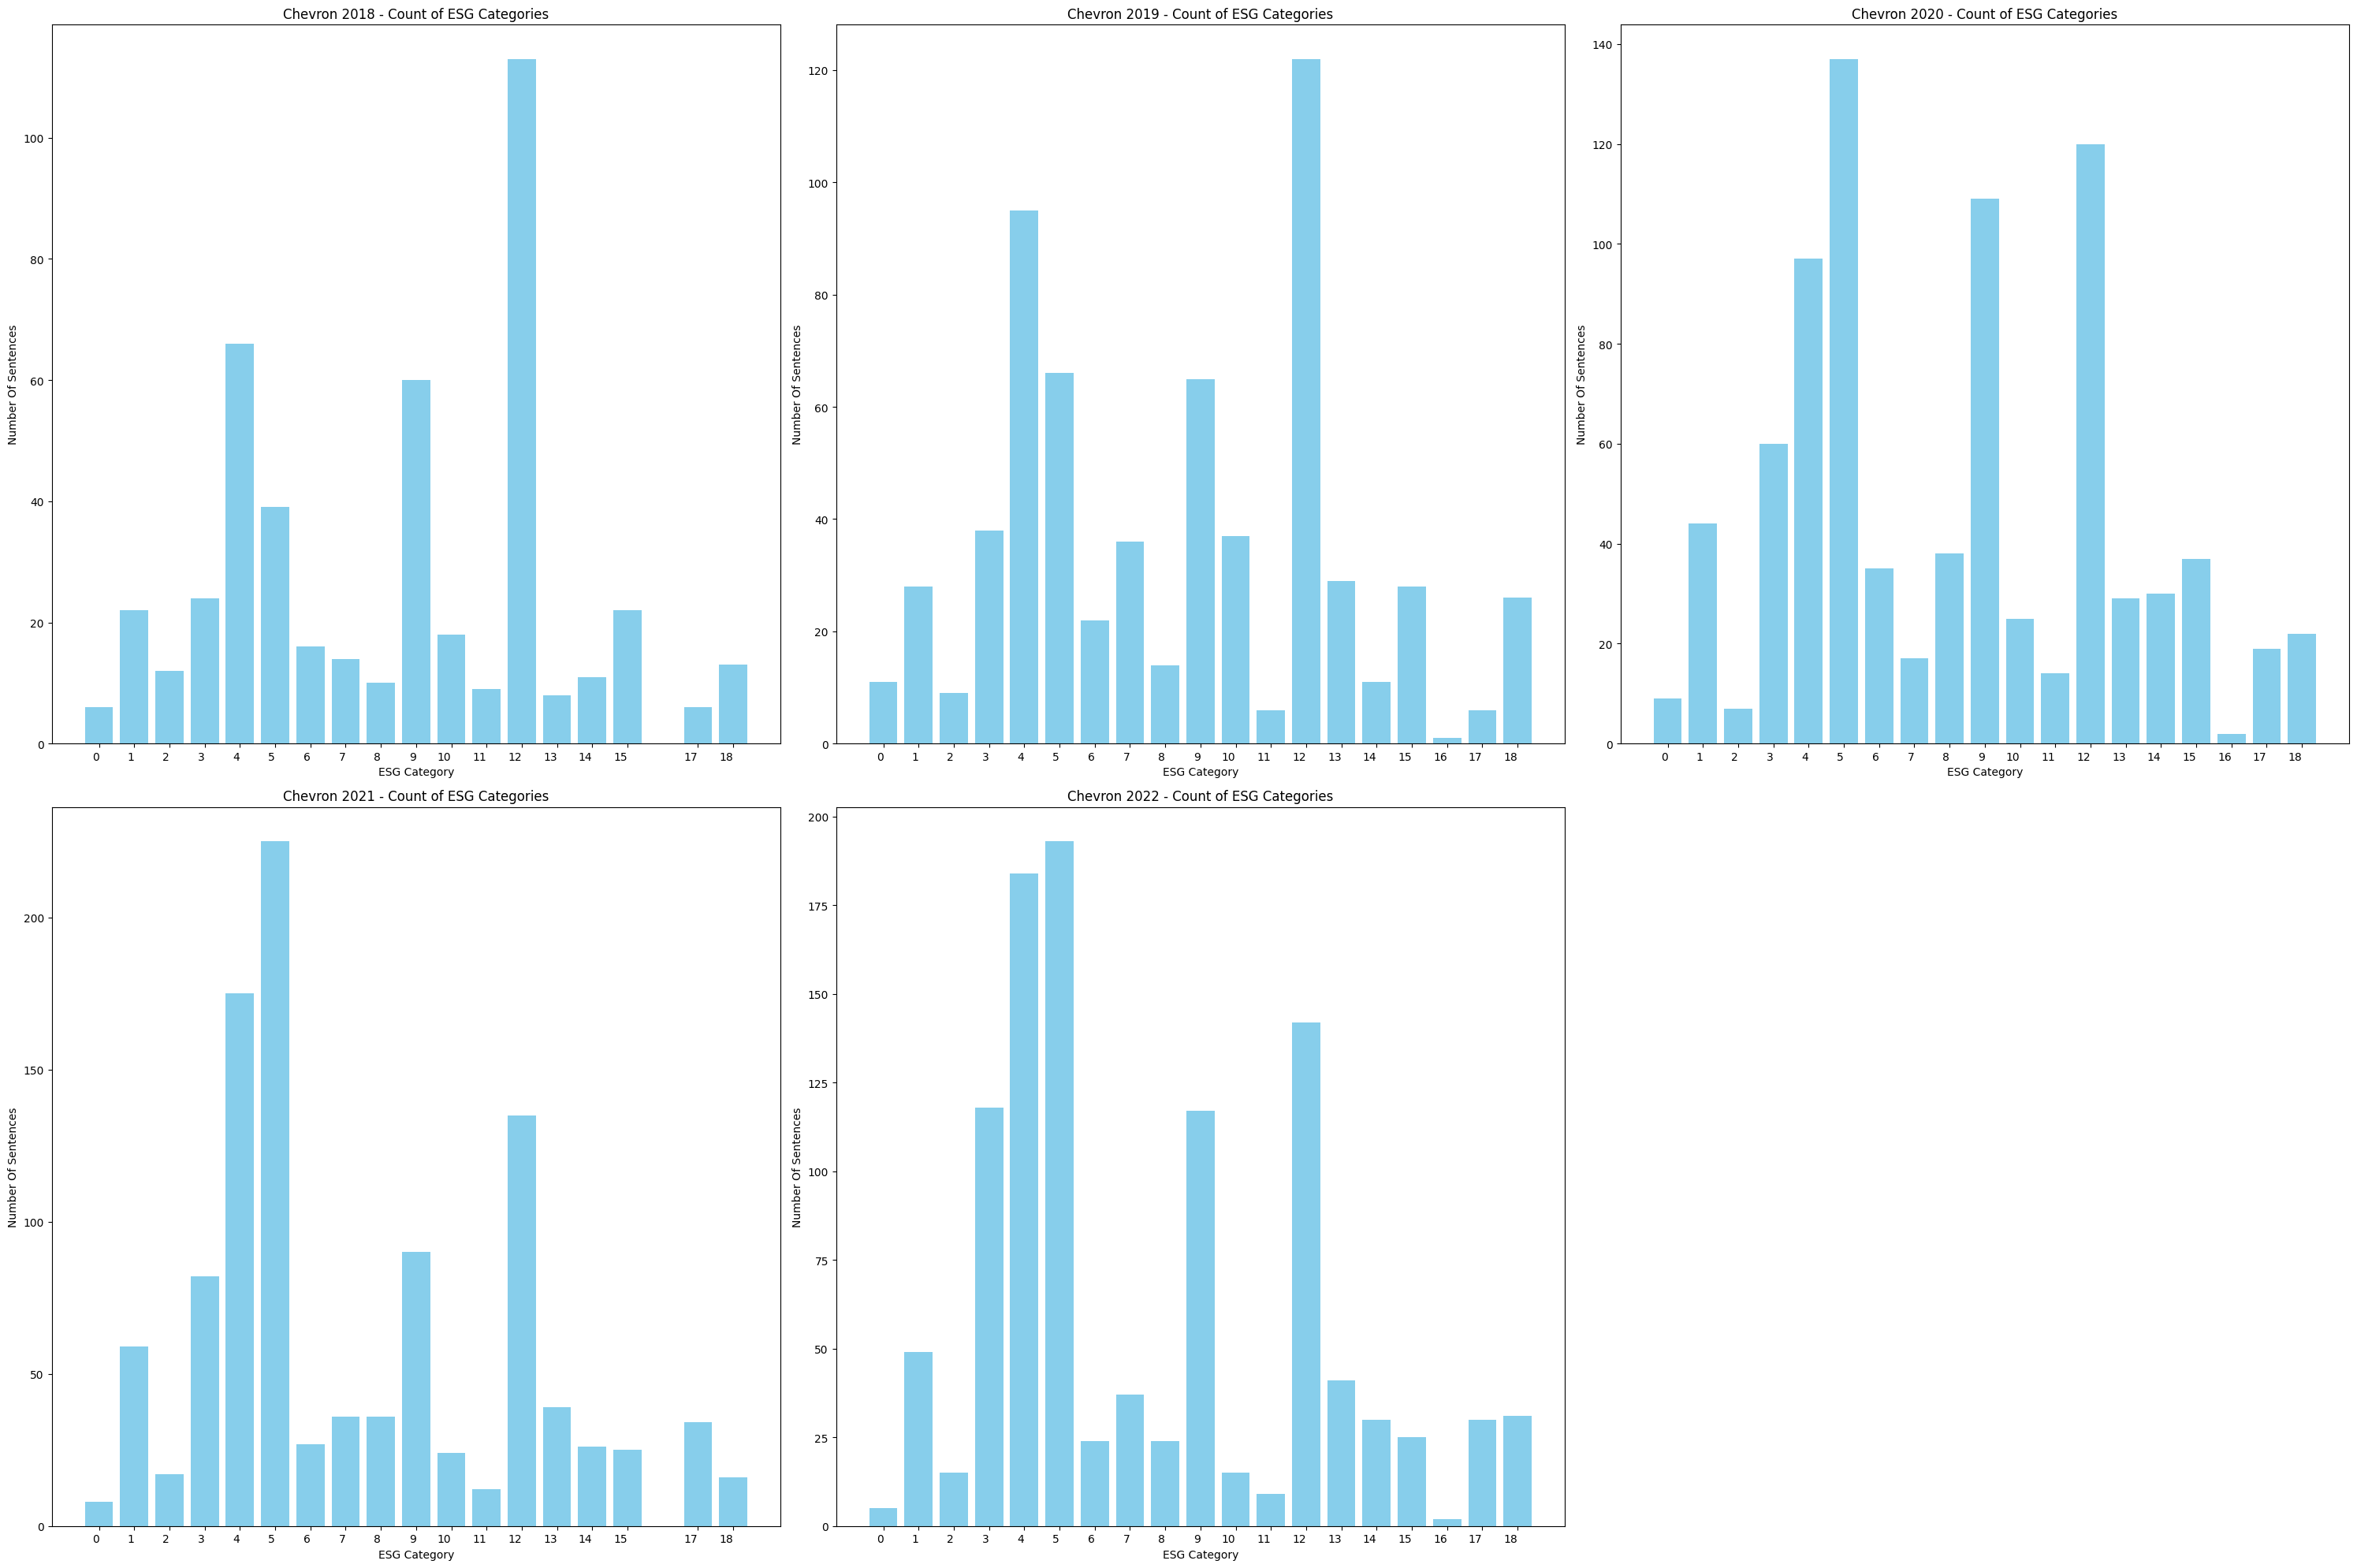

In [ ]:
plot_all(chevron_2022_df_id, chevron_name22_label, chevron_2021_df_id, chevron_name21_label, chevron_2020_df_id, chevron_name20_label, chevron_2019_df_id, chevron_name19_label, chevron_2018_df_id, chevron_name18_label)





# **General Motors**


---



***2022***

In [ ]:
gm_2022_df = analyze_report("""company,url
GM_2022, https://www.gmsustainability.com/_pdf/resources-and-downloads/GM_2022_SR.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
gm_2022_df.to_excel('gm_2022.xlsx')
files.download('gm_2022.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name22_label = "General Motors 2022 - Count of ESG Categories"
gm_name22_esg = "General Motors 2022 - ESG Distribution"

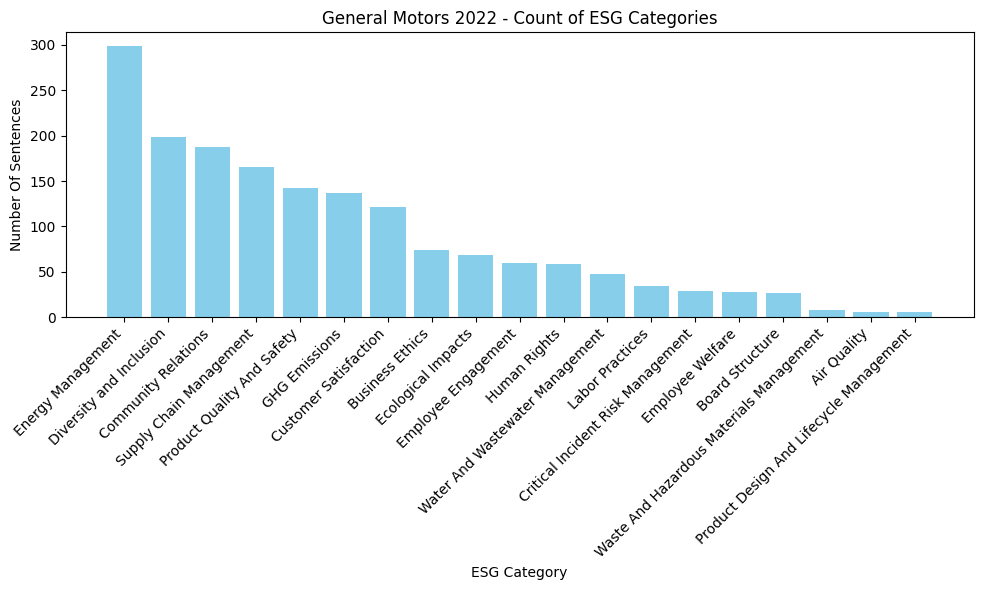

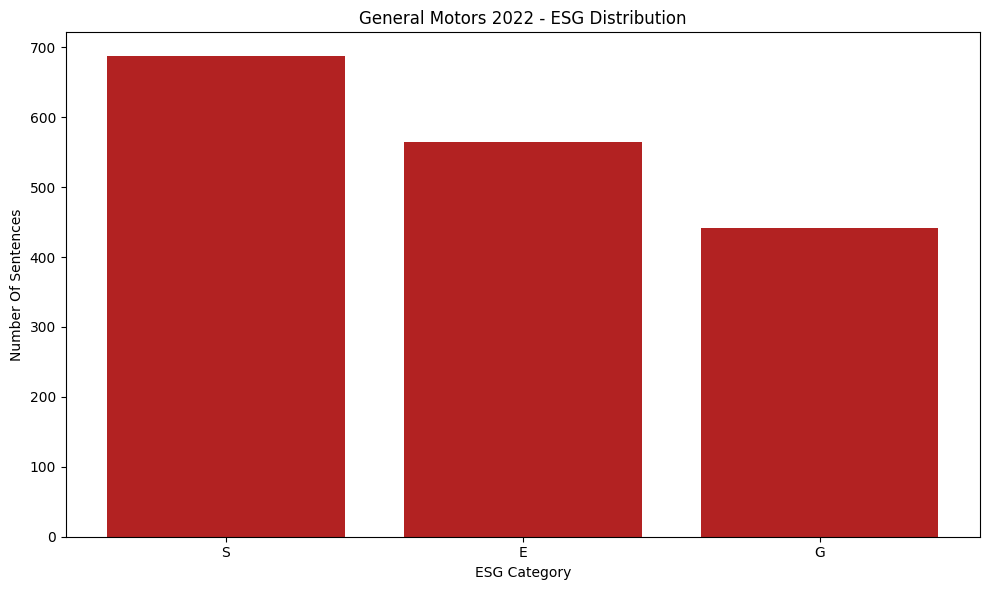

In [ ]:
plot_report(gm_2022_df, gm_name22_label, gm_name22_esg)

***2021***

In [ ]:
gm_2021_df = analyze_report("""company,url
GM_2021, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/g/NYSE_GM_2021.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
gm_2021_df.to_excel('gm_2021.xlsx')
files.download('gm_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name21_label = "General Motors 2021 - Count of ESG Categories"
gm_name21_esg = "General Motors 2021 - ESG Distribution"

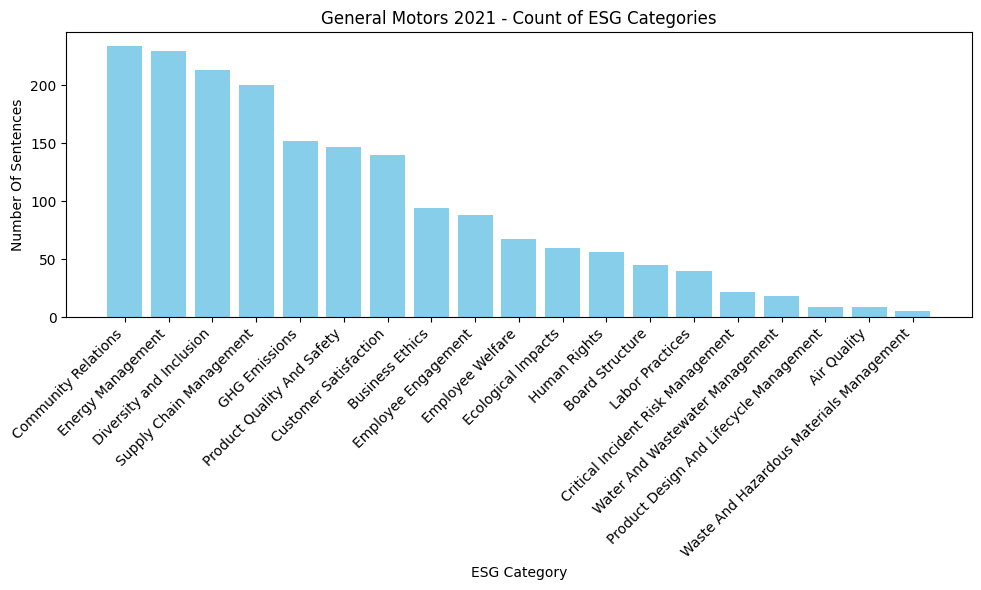

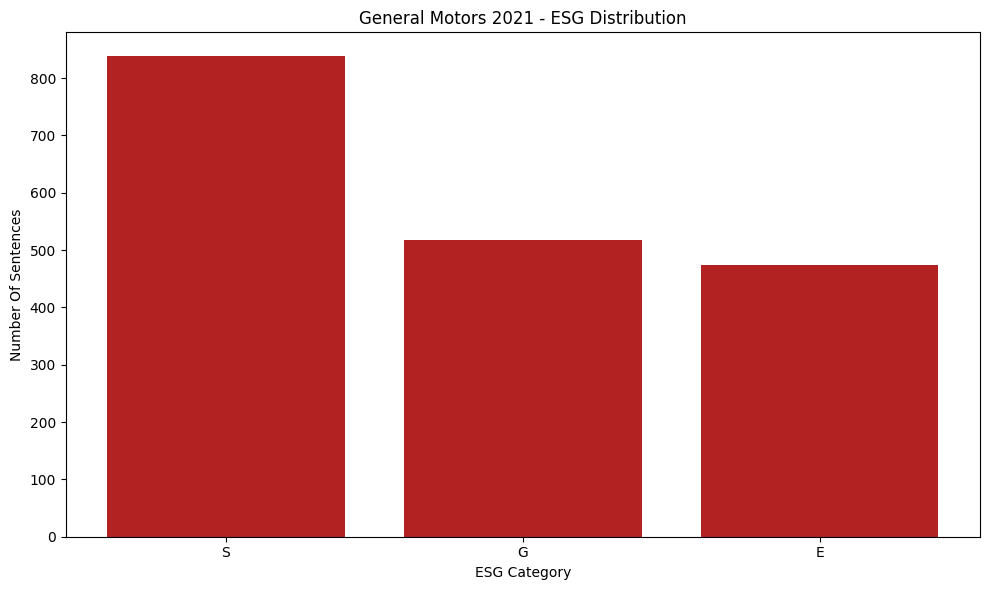

In [ ]:
plot_report(gm_2021_df, gm_name21_label, gm_name21_esg)

***2020***

In [ ]:
gm_2020_df = analyze_report("""company,url
GM_2020, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/g/NYSE_GM_2020.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
gm_2020_df.to_excel('gm_2020.xlsx')
files.download('gm_2020.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name20_label = "General Motors 2020 - Count of ESG Categories"
gm_name20_esg = "General Motors 2020 - ESG Distribution"

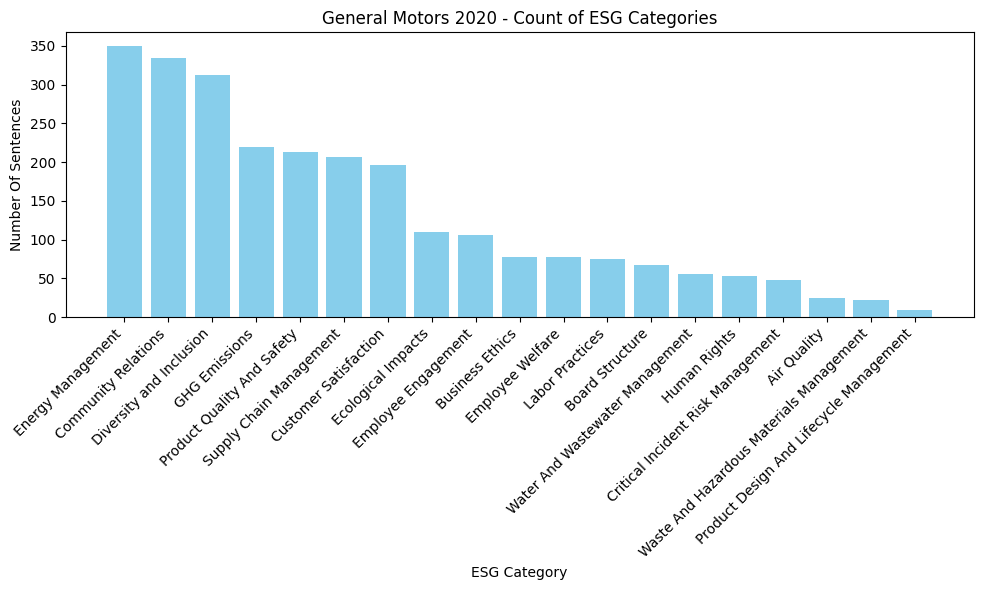

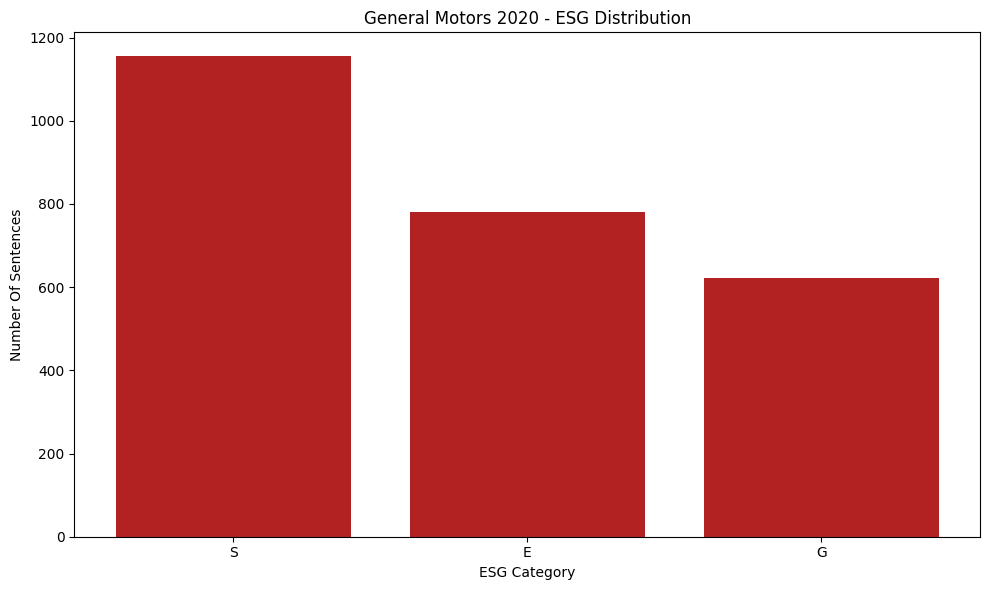

In [ ]:
plot_report(gm_2020_df, gm_name20_label, gm_name20_esg)

***2019***

In [ ]:
gm_2019_df = analyze_report("""company,url
GM_2019, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/g/NYSE_GM_2019.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
gm_2019_df.to_excel('gm_2019.xlsx')
files.download('gm_2019.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name19_label = "General Motors 2019 - Count of ESG Categories"
gm_name19_esg = "General Motors 2019 - ESG Distribution"

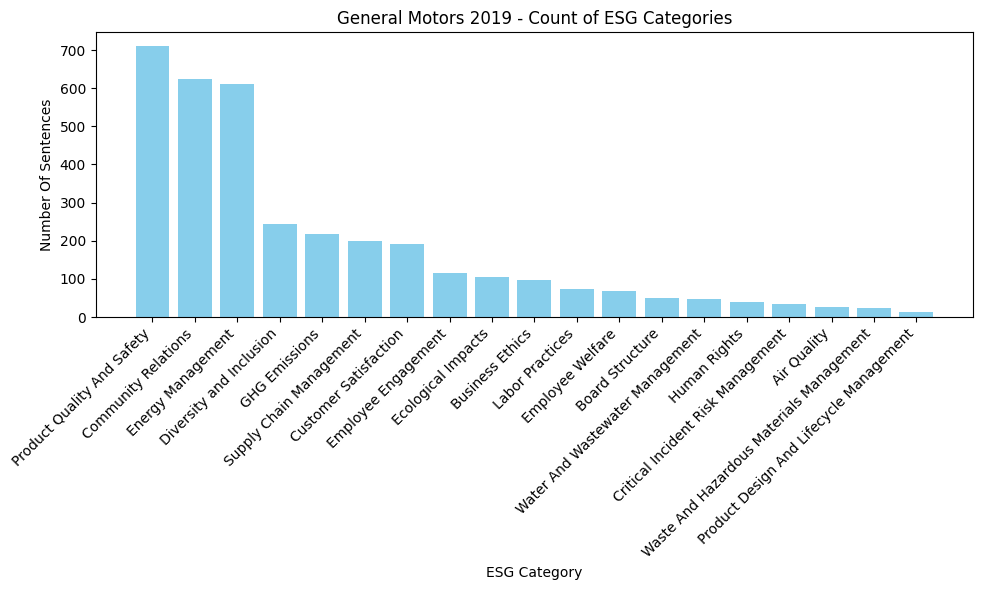

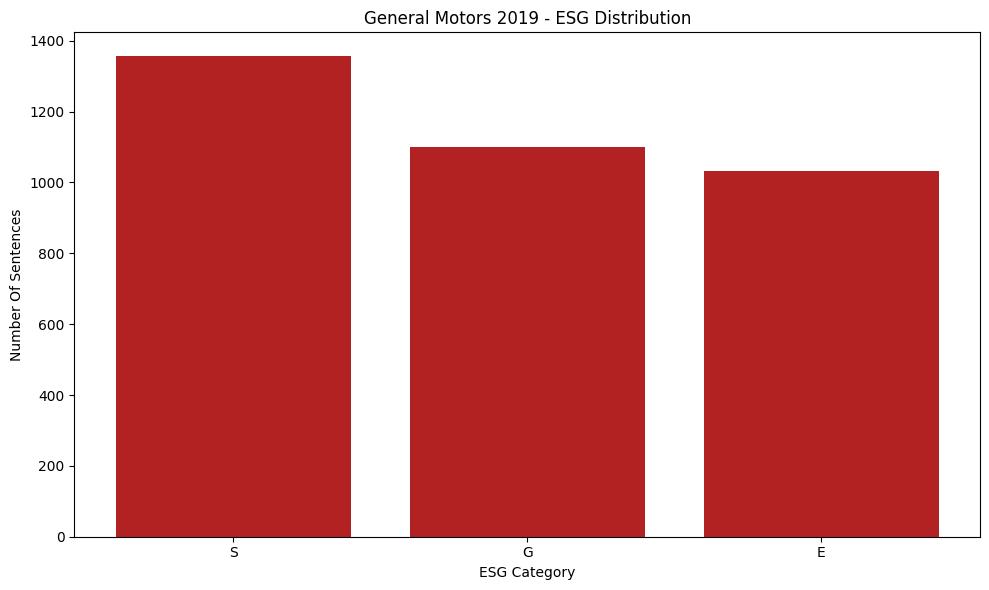

In [ ]:
plot_report(gm_2019_df, gm_name19_label, gm_name19_esg)

***2018***

In [ ]:
gm_2018_df = analyze_report("""company,url
GM_2018, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/g/NYSE_GM_2018.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
gm_2018_df.to_excel('gm_2018.xlsx')
files.download('gm_2018.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gm_name18_label = "General Motors 2018 - Count of ESG Categories"
gm_name18_esg = "General Motors 2018 - ESG Distribution"

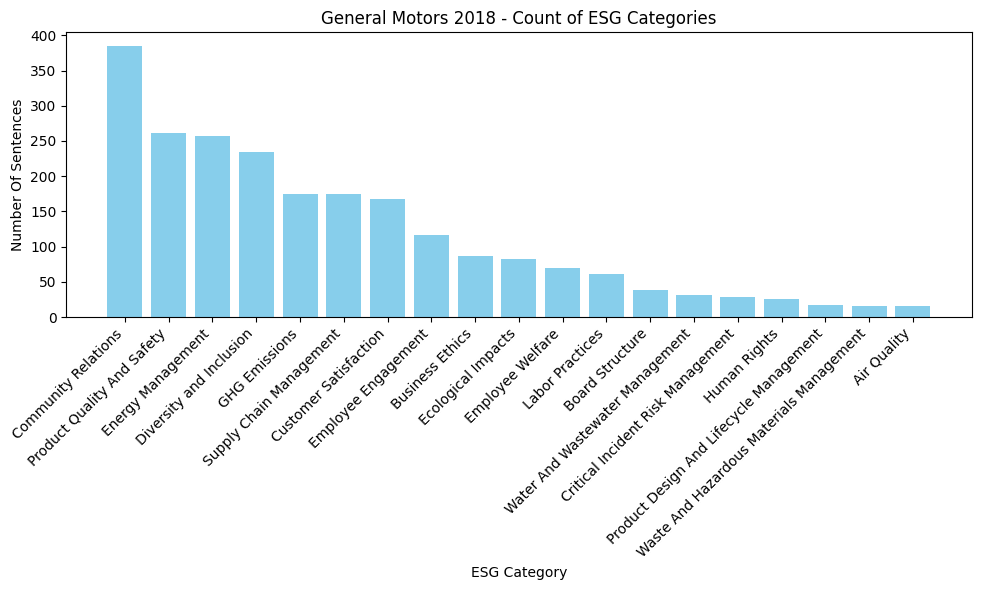

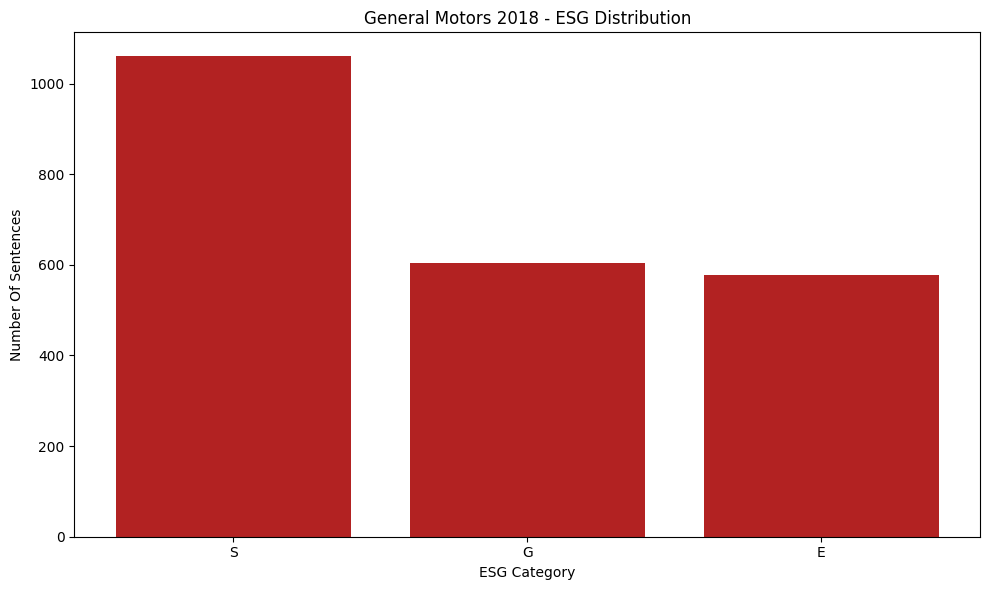

In [ ]:
plot_report(gm_2018_df, gm_name18_label, gm_name18_esg)

***Comparison***

In [ ]:
gm_2022_df_id = count_id(gm_2022_df)
gm_2021_df_id = count_id(gm_2021_df)
gm_2020_df_id = count_id(gm_2020_df)
gm_2019_df_id = count_id(gm_2019_df)
gm_2018_df_id = count_id(gm_2018_df)

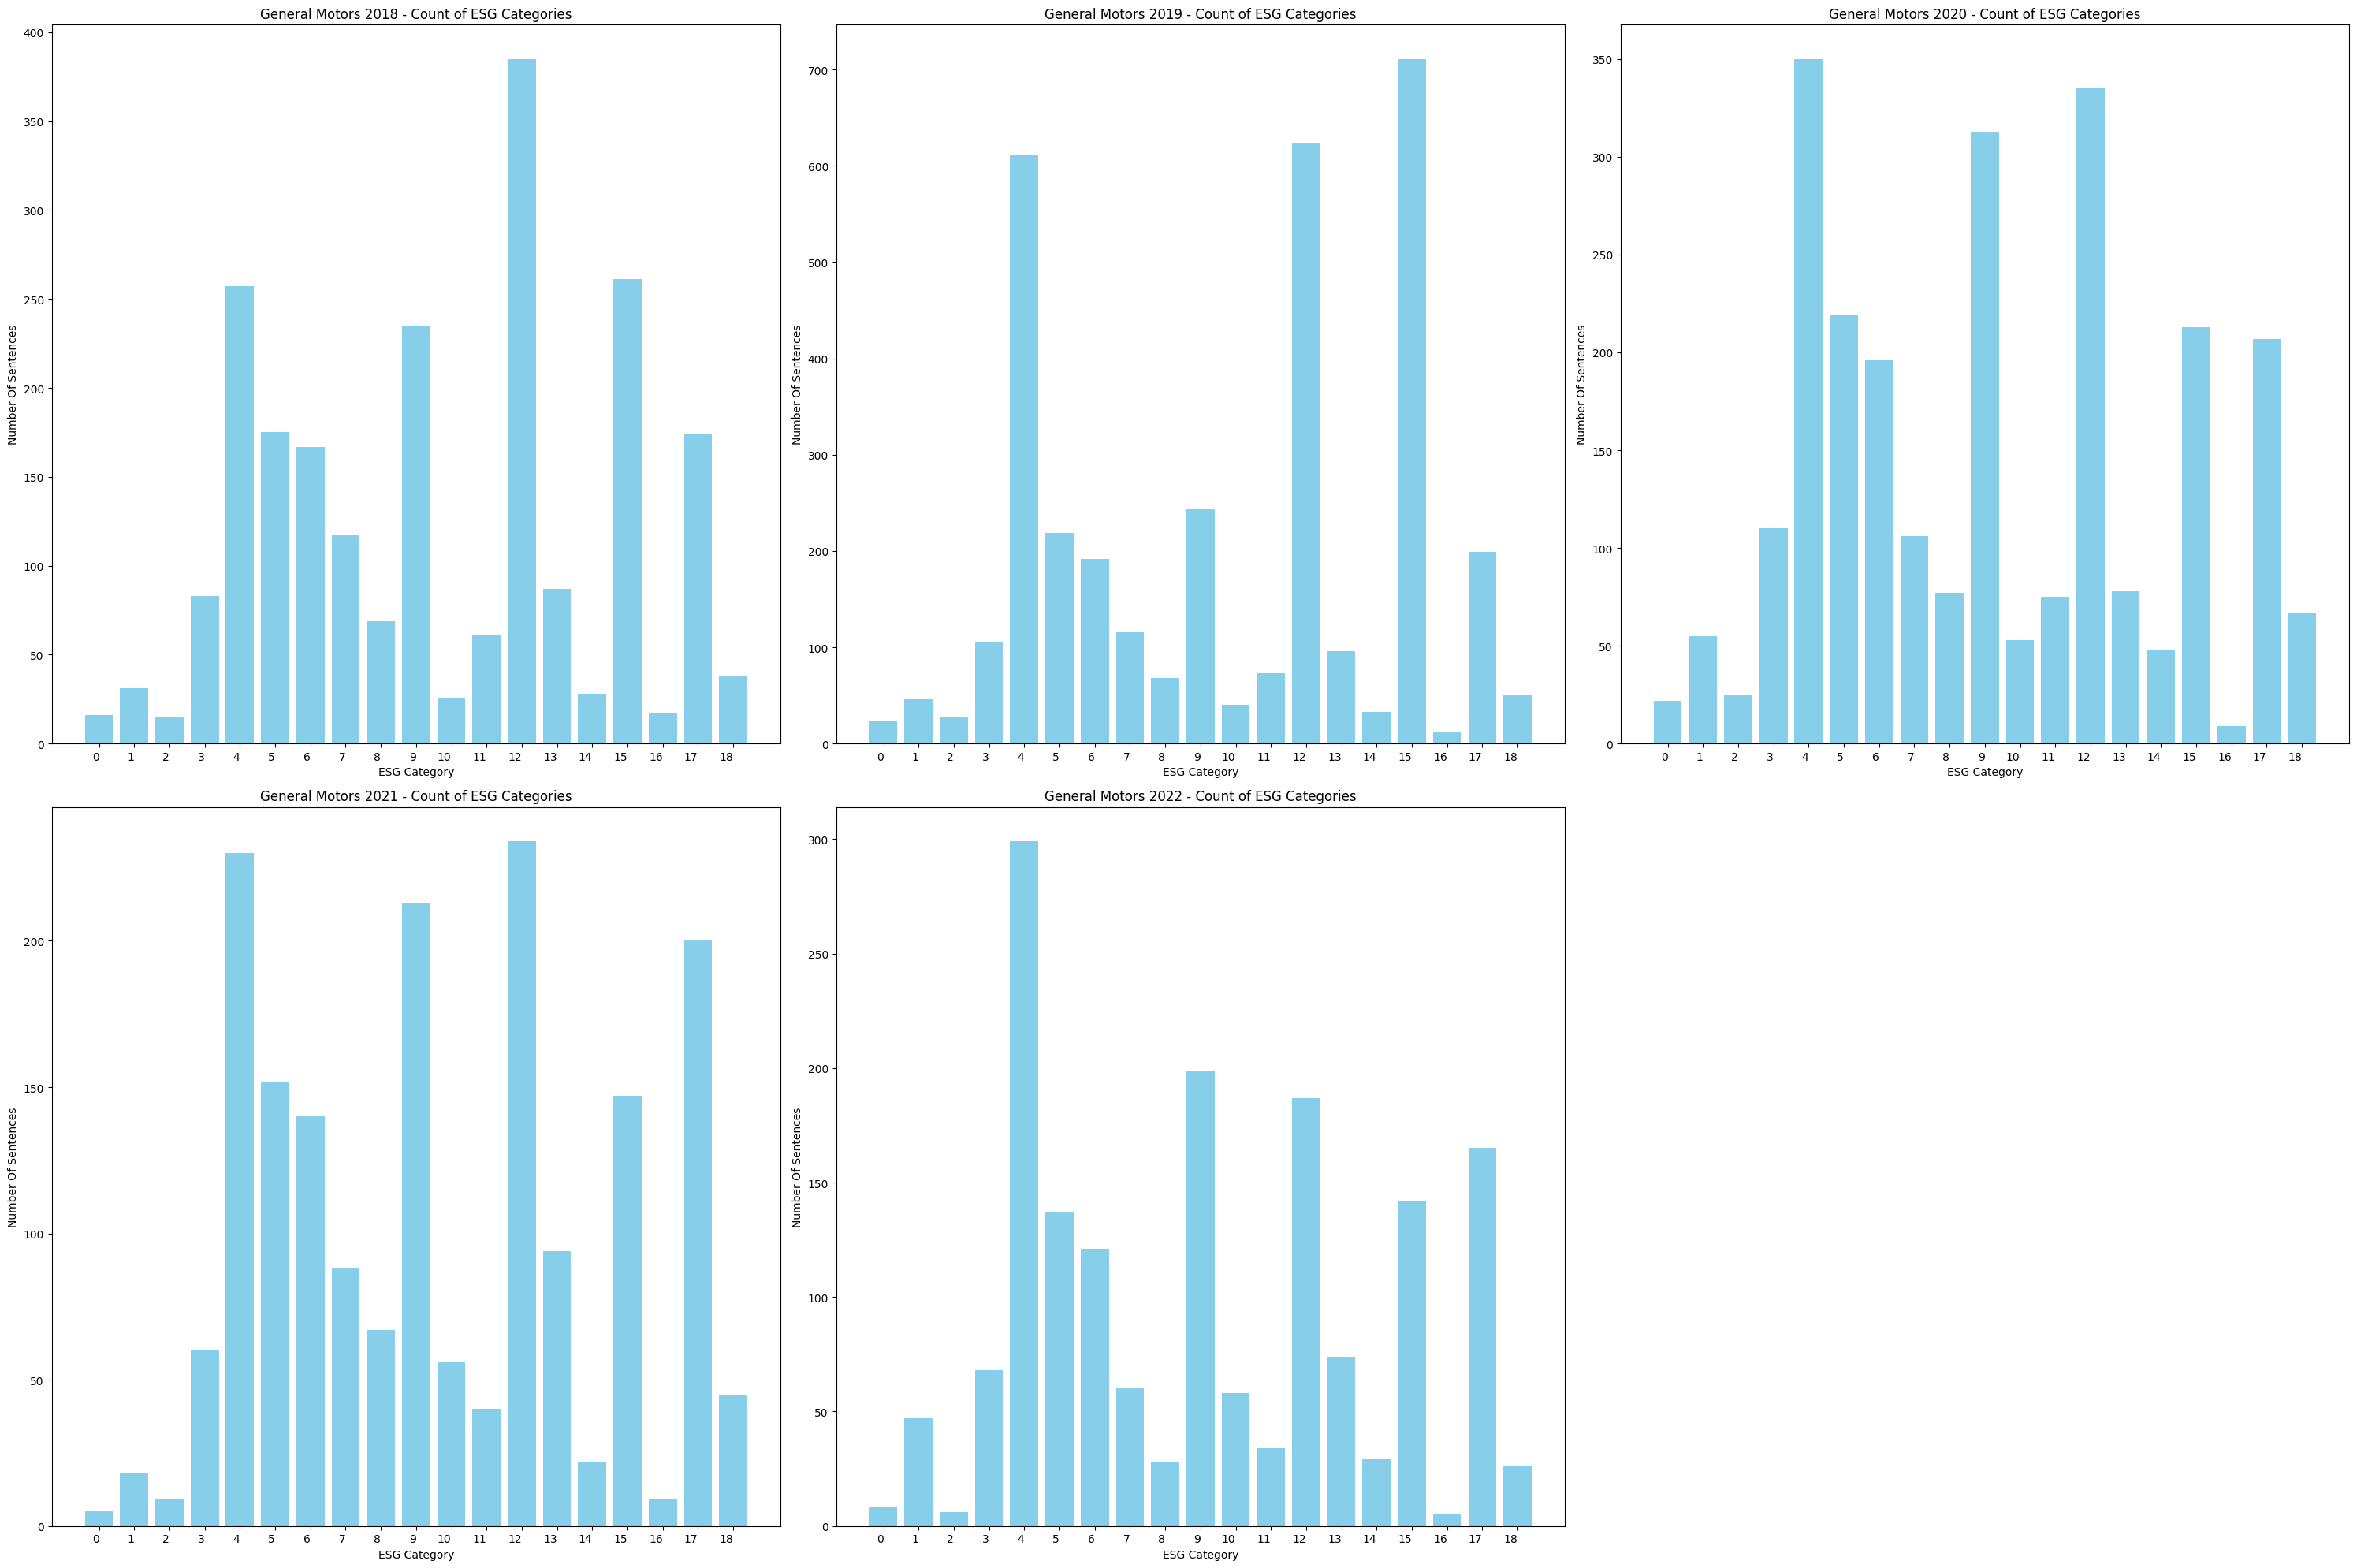

In [ ]:
plot_all(gm_2022_df_id, gm_name22_label, gm_2021_df_id, gm_name21_label, gm_2020_df_id, gm_name20_label, gm_2019_df_id, gm_name19_label, gm_2018_df_id, gm_name18_label)





# **JP Morgan**


---



***2022***

In [ ]:
jpm_2022_df = analyze_report("""company,url
JPM_2022, https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_JPM_2022.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
jpm_2022_df.to_excel('jpm_2022.xlsx')
files.download('jpm_2022.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name22_label = "JP Morgan 2022 - Count of ESG Categories"
jpm_name22_esg = "JP Morgan 2022 - ESG Distribution"

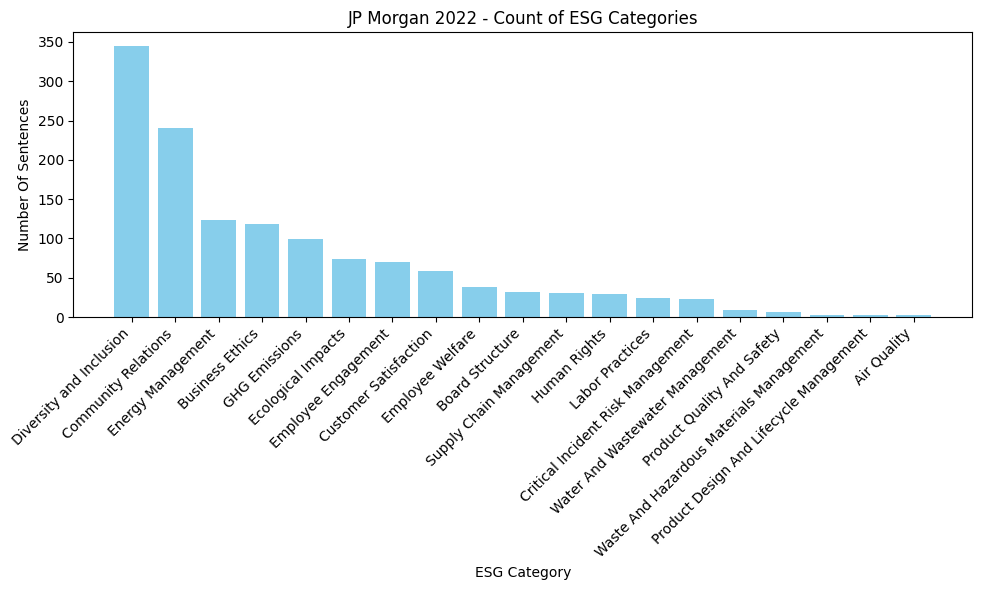

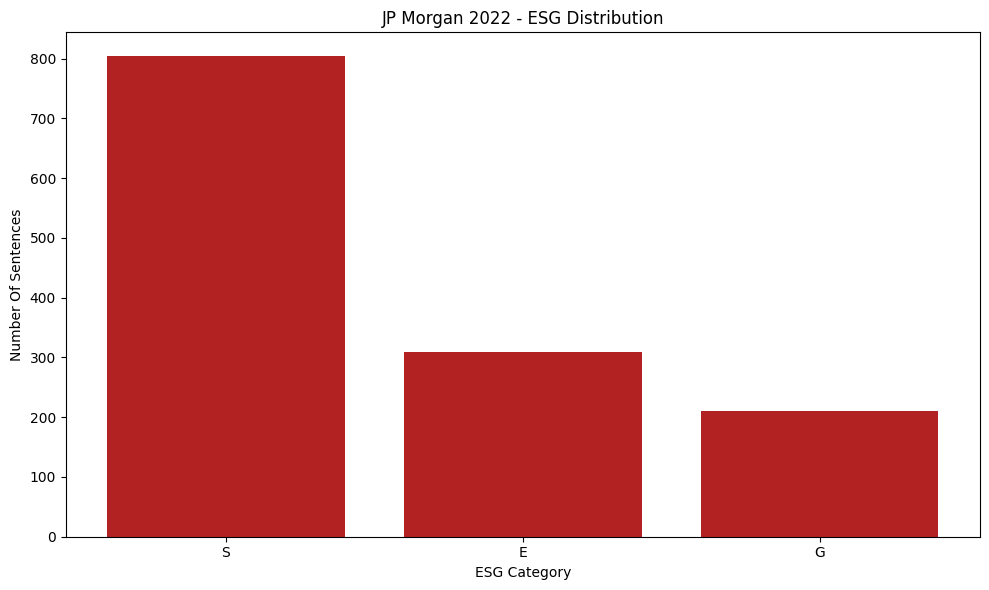

In [ ]:
plot_report(jpm_2022_df, jpm_name22_label, jpm_name22_esg)

***2021***

In [ ]:
jpm_2021_df = analyze_report("""company,url
JPM_2021, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/j/NYSE_JPM_2021.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
jpm_2021_df.to_excel('jpm_2021.xlsx')
files.download('jpm_2021.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name21_label = "JP Morgan 2021 - Count of ESG Categories"
jpm_name21_esg = "JP Morgan 2021 - ESG Distribution"

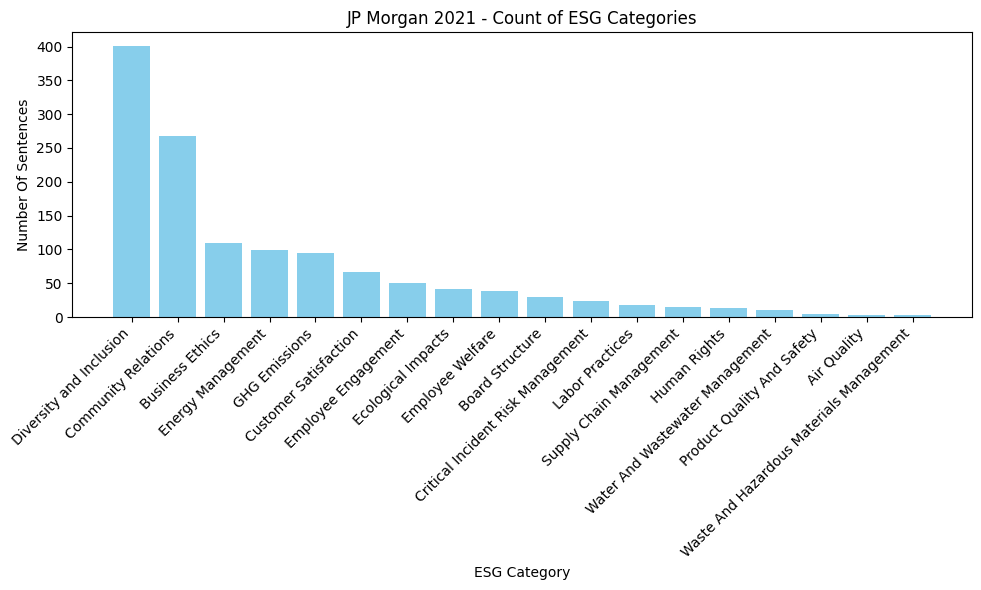

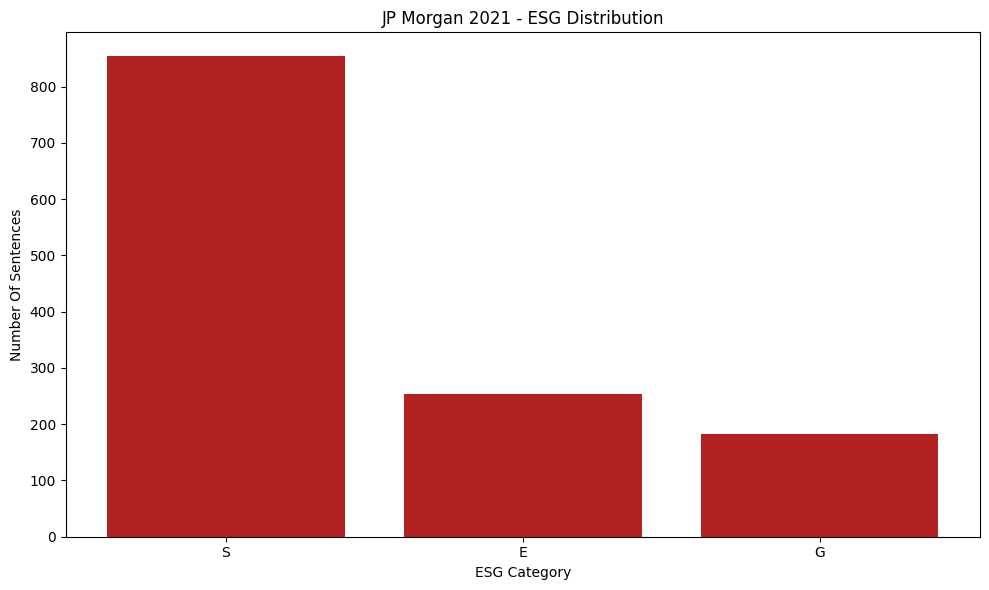

In [ ]:
plot_report(jpm_2021_df, jpm_name21_label, jpm_name21_esg)

***2020***

In [ ]:
jpm_2020_df = analyze_report("""company,url
JPM_2020, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/j/NYSE_JPM_2020.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
jpm_2020_df.to_excel('jpm_2020.xlsx')
files.download('jpm_2020.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name20_label = "JP Morgan 2020 - Count of ESG Categories"
jpm_name20_esg = "JP Morgan 2020 - ESG Distribution"

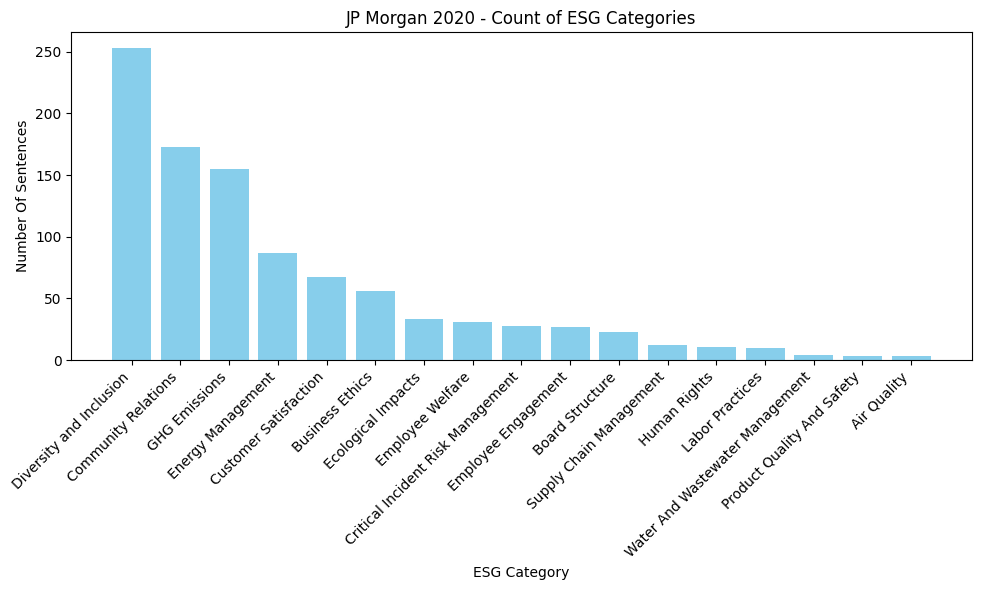

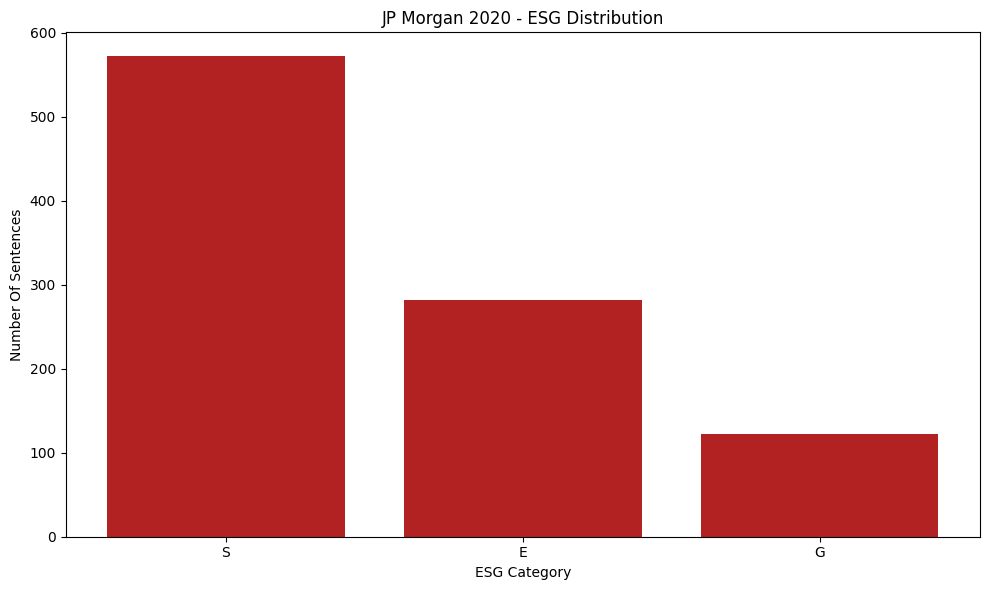

In [ ]:
plot_report(jpm_2020_df, jpm_name20_label, jpm_name20_esg)

***2019***

In [ ]:
jpm_2019_df = analyze_report("""company,url
JPM_2019, https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/j/NYSE_JPM_2019.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1090: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
jpm_2019_df.to_excel('jpm_2019.xlsx')
files.download('jpm_2019.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name19_label = "JP Morgan 2019 - Count of ESG Categories"
jpm_name19_esg = "JP Morgan 2019 - ESG Distribution"

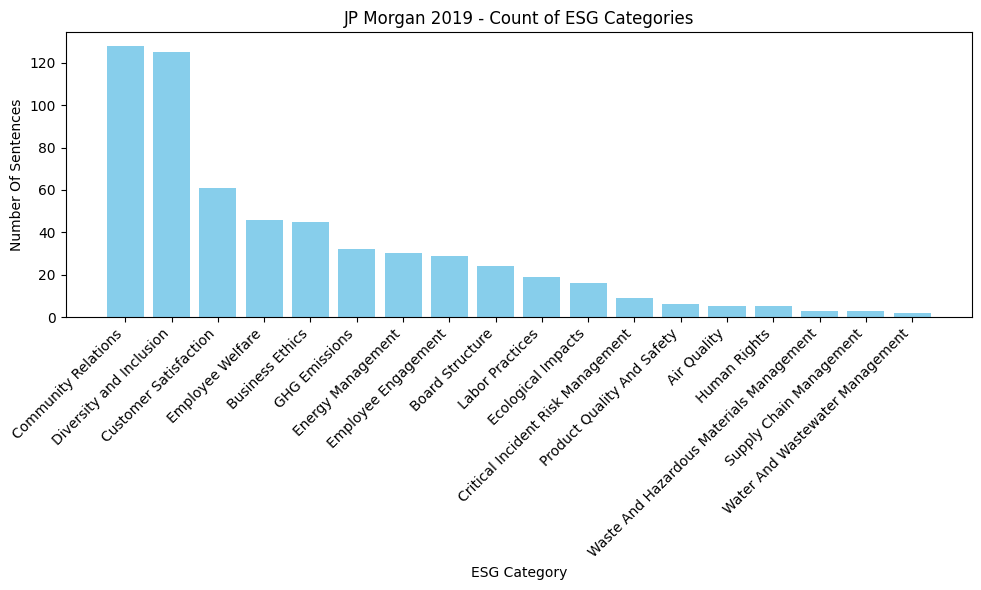

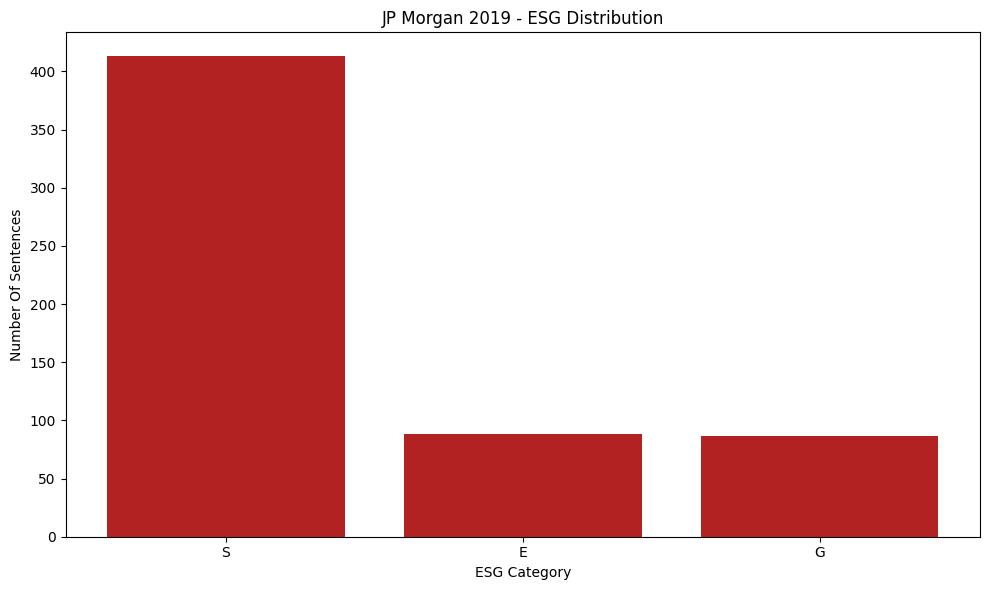

In [ ]:
plot_report(jpm_2019_df, jpm_name19_label, jpm_name19_esg)

***2018***

In [ ]:
jpm_2018_df = analyze_report("""company,url
JPM_2018, https://www.jpmorganchase.com/content/dam/jpmc/jpmorgan-chase-and-co/documents/jpmc-cr-esg-report-2018.pdf""")

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [ ]:
jpm_2018_df.to_excel('jpm_2018.xlsx')
files.download('jpm_2018.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
jpm_name18_label = "JP Morgan 2018 - Count of ESG Categories"
jpm_name18_esg = "JP Morgan 2018 - ESG Distribution"

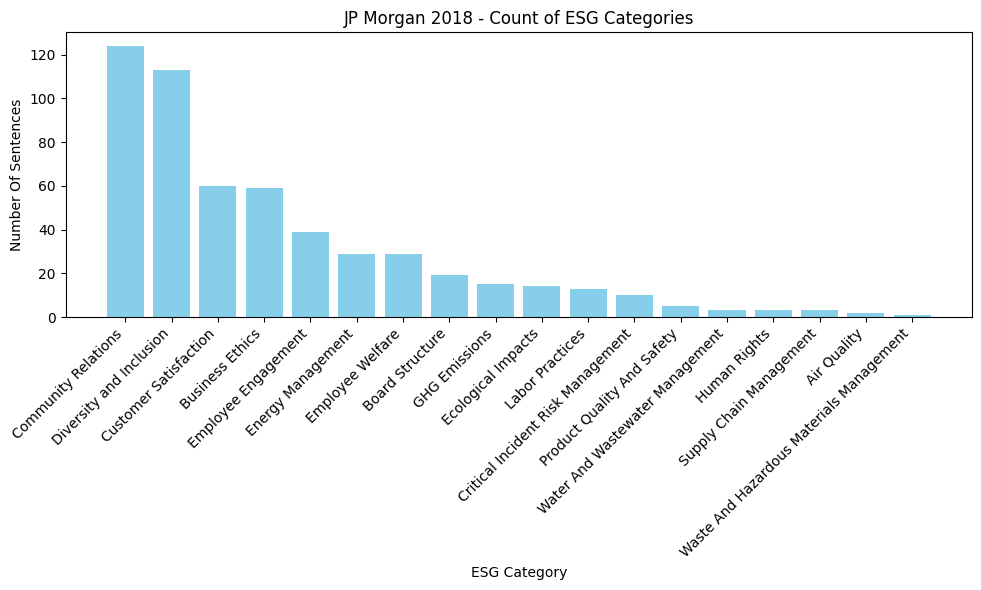

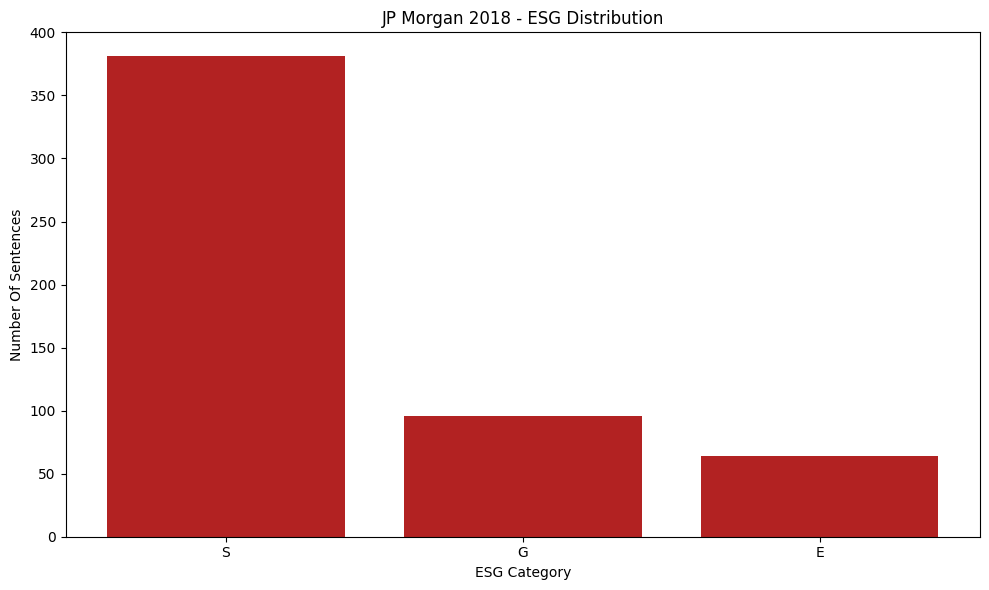

In [ ]:
plot_report(jpm_2018_df, jpm_name18_label, jpm_name18_esg)

***Comparison***

In [ ]:
jpm_2022_df_id = count_id(jpm_2022_df)
jpm_2021_df_id = count_id(jpm_2021_df)
jpm_2020_df_id = count_id(jpm_2020_df)
jpm_2019_df_id = count_id(jpm_2019_df)
jpm_2018_df_id = count_id(jpm_2018_df)

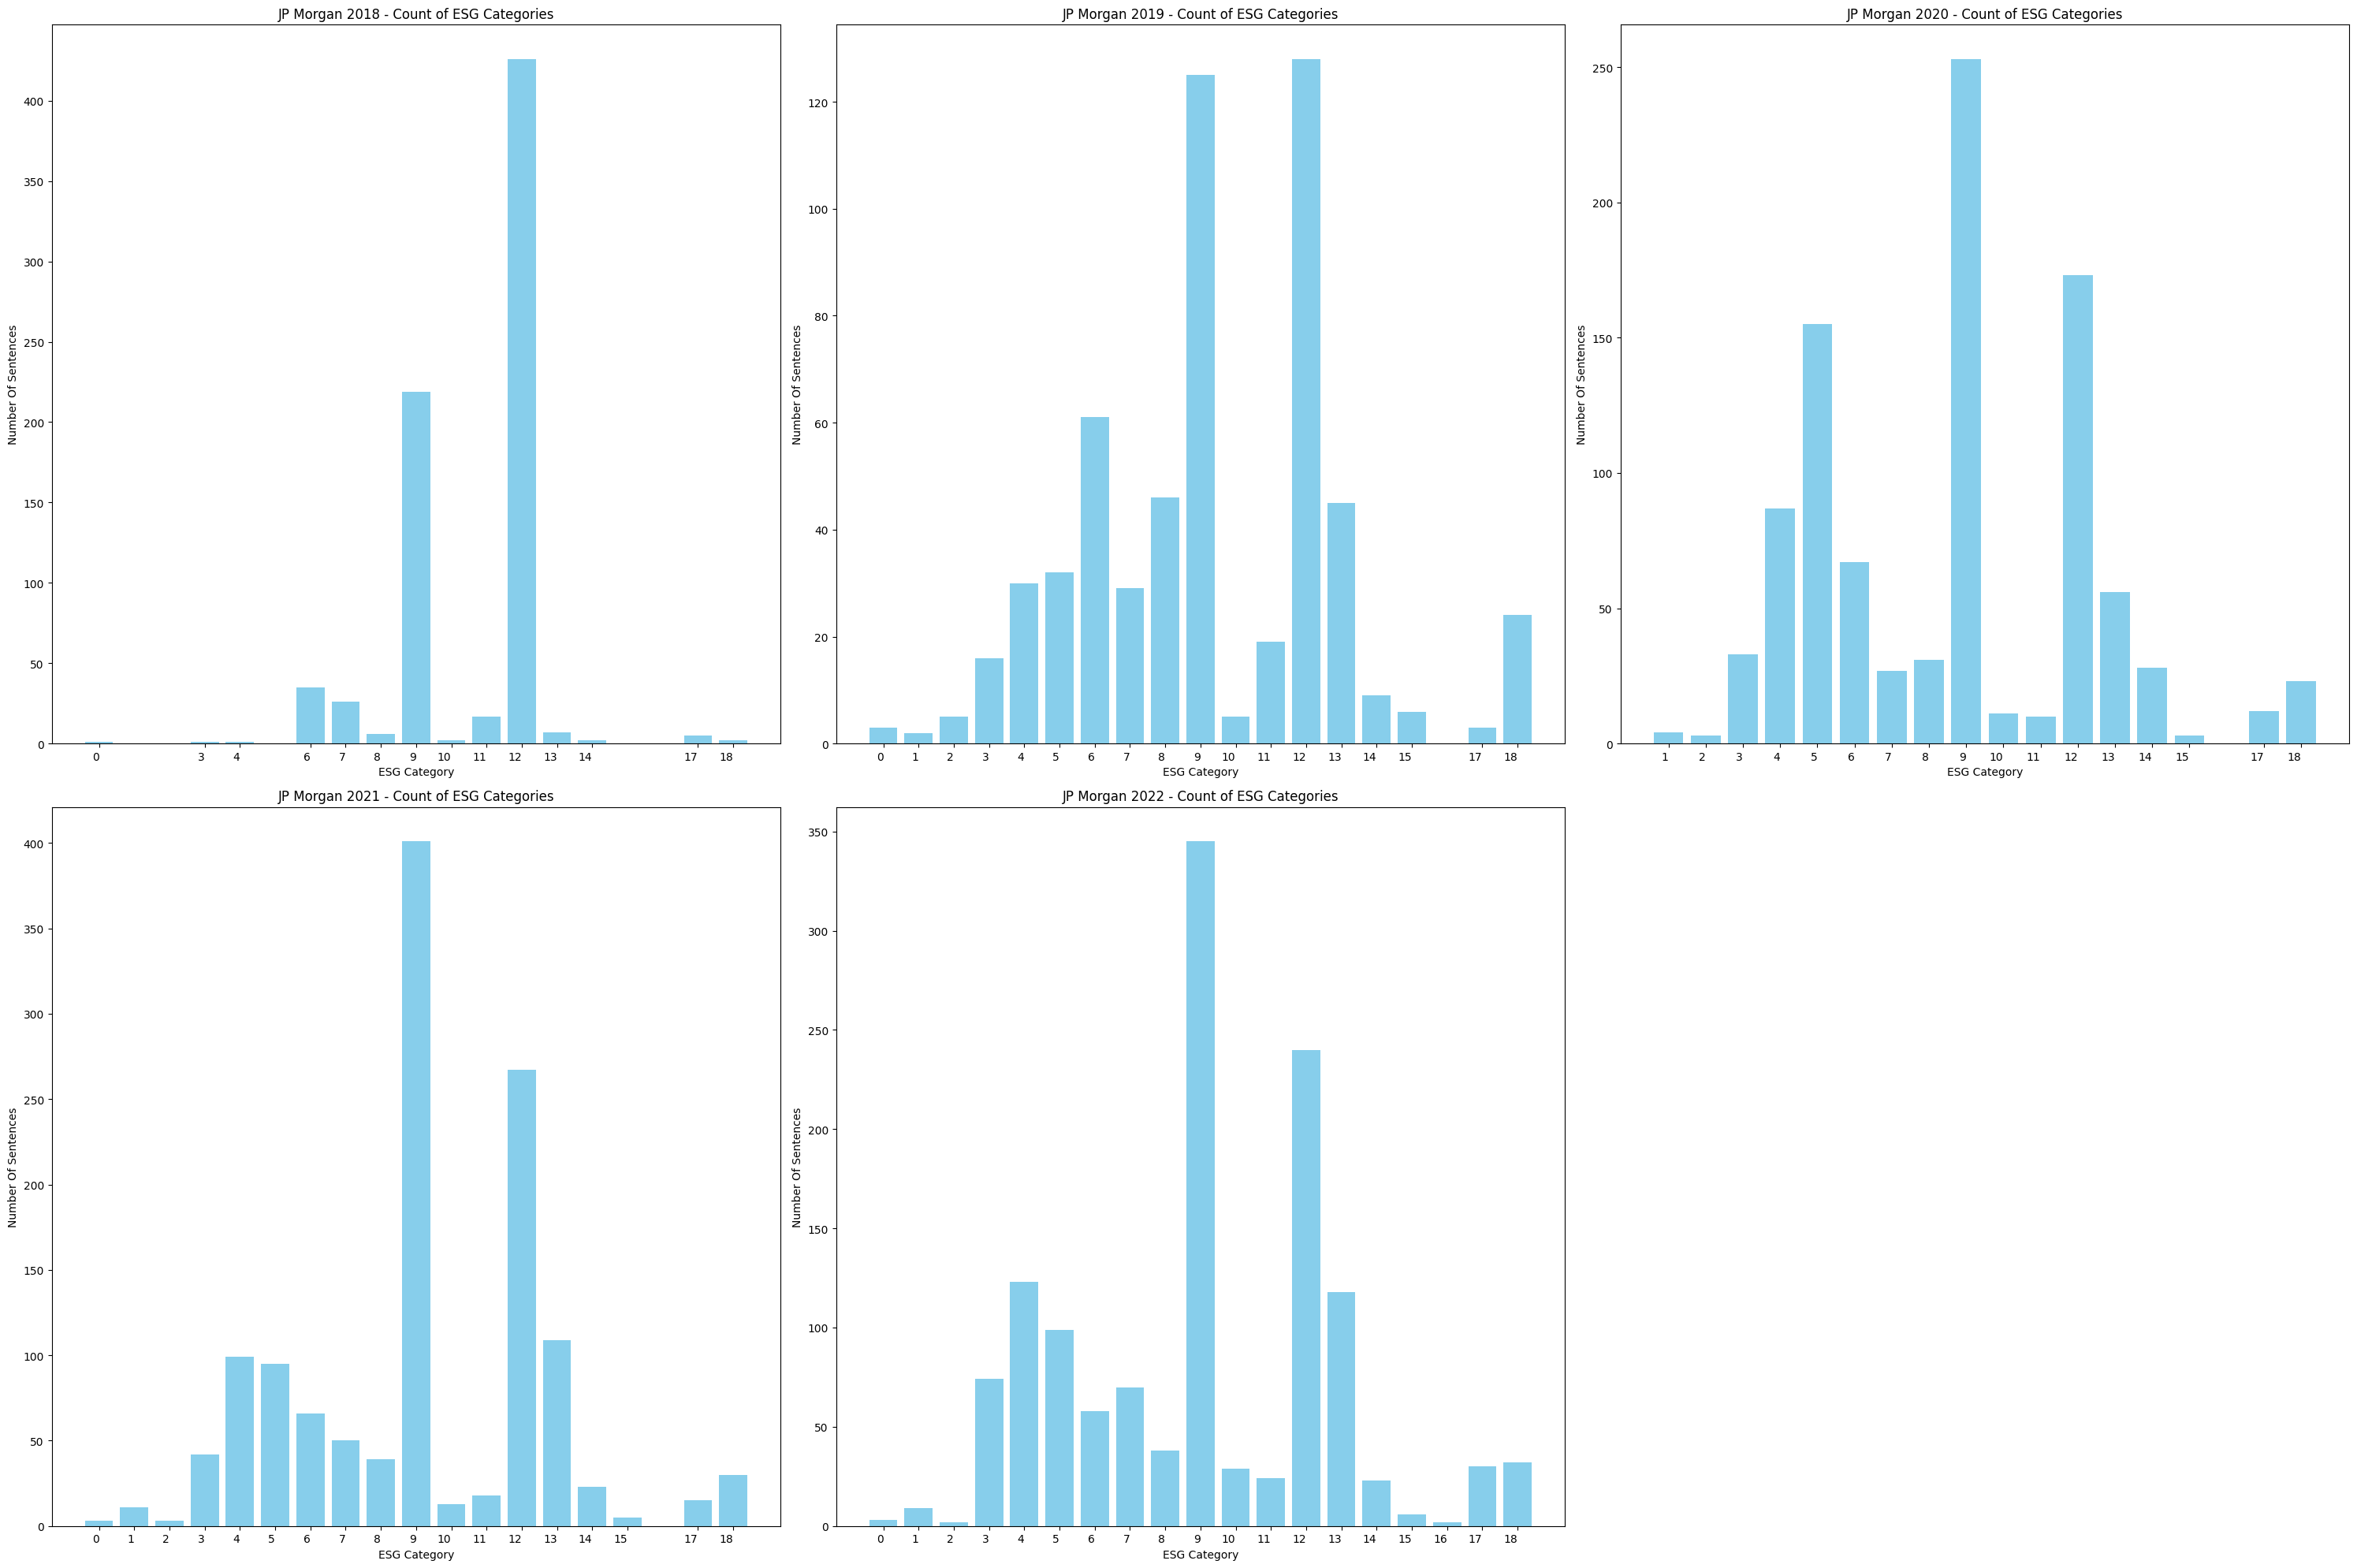

In [ ]:
plot_all(jpm_2022_df_id, jpm_name22_label, jpm_2021_df_id, jpm_name21_label, jpm_2020_df_id, jpm_name20_label, jpm_2019_df_id, jpm_name19_label, jpm_2018_df_id, jpm_name18_label)